## Navigate to the Correct Directory

The following code navigates to the dataprocessing directory.

In [1]:
cd ../dataprocessing

## Call the import statements

The following code imports the necessary code to run the code in the rest of this notebook.

In [99]:
# import statements
import audio_processing as ap

import functools
import os
import sys
from absl import logging

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import sklearn

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

Ran the import statements.


In [3]:
# set logging to print logging.INFO logs
logging.set_verbosity(logging.INFO)

In [4]:
# arguments for audio_processing
src_dir = 'example_src_dir'
dest_dir = 'example_dest_dir'
filename = 'test_set2'
labels = ['Gunshot, gunfire']
available_features = ['chroma_stft',
                       'chroma_cqt',
                       'chroma_cens',
                       'melspectrogram',
                       'mfcc',
                       'rms',
                       'spectral_centroid',
                       'spectral_bandwidth',
                       'spectral_contrast',
                       'spectral_flatness',
                       'spectral_rolloff',
                       'poly_features',
                       'tonnetz',
                       'zero_crossing_rate'
]
features_to_extract = ['rms']

In [6]:
# Import the dataset
df = ap.output_df(src_dir, dest_dir, filename, labels, features_to_extract, False)

INFO:absl:The set has 13420 examples
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:a

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Alre

INFO:absl:(27, 25.786598)
INFO:absl:extracted features
INFO:absl:(28, 26.285036)
INFO:absl:extracted features
INFO:absl:(29, 26.785543)
INFO:absl:extracted features
INFO:absl:(30, 27.283983)
INFO:absl:extracted features
INFO:absl:(31, 27.774023)
INFO:absl:extracted features
INFO:absl:(32, 28.266087)
INFO:absl:extracted features
INFO:absl:(33, 28.753235)
INFO:absl:extracted features
INFO:absl:(34, 29.227555)
INFO:absl:extracted features
INFO:absl:(35, 29.721518)
INFO:absl:extracted features
INFO:absl:(36, 30.19296)
INFO:absl:extracted features
INFO:absl:(37, 30.661395)
INFO:absl:extracted features
INFO:absl:(38, 31.159292)
INFO:absl:extracted features
INFO:absl:(39, 31.661177)
INFO:absl:extracted features
INFO:absl:(40, 32.162464)
INFO:absl:extracted features
INFO:absl:(41, 32.657907)
INFO:absl:extracted features
INFO:absl:(42, 33.15456)
INFO:absl:extracted features
INFO:absl:(43, 33.651748)
INFO:absl:extracted features
INFO:absl:(44, 34.145928)
INFO:absl:extracted features
INFO:absl:(4

INFO:absl:extracted features
INFO:absl:(175, 97.549092)
INFO:absl:extracted features
INFO:absl:(176, 98.04951)
INFO:absl:extracted features
INFO:absl:(177, 98.552374)
INFO:absl:extracted features
INFO:absl:(178, 99.031199)
INFO:absl:extracted features
INFO:absl:(179, 99.531956)
INFO:absl:extracted features
INFO:absl:(180, 100.032497)
INFO:absl:extracted features
INFO:absl:(181, 100.53263)
INFO:absl:extracted features
INFO:absl:(182, 100.96856)
INFO:absl:extracted features
INFO:absl:(183, 101.465435)
INFO:absl:extracted features
INFO:absl:(184, 101.965567)
INFO:absl:extracted features
INFO:absl:(185, 102.468075)
INFO:absl:extracted features
INFO:absl:(186, 102.948325)
INFO:absl:extracted features
INFO:absl:(187, 103.424037)
INFO:absl:extracted features
INFO:absl:(188, 103.907547)
INFO:absl:extracted features
INFO:absl:(189, 104.381221)
INFO:absl:extracted features
INFO:absl:(190, 104.857831)
INFO:absl:extracted features
INFO:absl:(191, 105.361471)
INFO:absl:extracted features
INFO:absl:

INFO:absl:(319, 167.629434)
INFO:absl:extracted features
INFO:absl:(320, 168.129535)
INFO:absl:extracted features
INFO:absl:(321, 168.626901)
INFO:absl:extracted features
INFO:absl:(322, 169.125617)
INFO:absl:extracted features
INFO:absl:(323, 169.59849)
INFO:absl:extracted features
INFO:absl:(324, 170.086506)
INFO:absl:extracted features
INFO:absl:(325, 170.534289)
INFO:absl:extracted features
INFO:absl:(326, 171.03152)
INFO:absl:extracted features
INFO:absl:(327, 171.530141)
INFO:absl:extracted features
INFO:absl:(328, 172.03193)
INFO:absl:extracted features
INFO:absl:(329, 172.529262)
INFO:absl:extracted features
INFO:absl:(330, 173.012031)
INFO:absl:extracted features
INFO:absl:(331, 173.450466)
INFO:absl:extracted features
INFO:absl:(332, 173.952934)
INFO:absl:extracted features
INFO:absl:(333, 174.445256)
INFO:absl:extracted features
INFO:absl:(334, 174.935911)
INFO:absl:extracted features
INFO:absl:(335, 175.433507)
INFO:absl:extracted features
INFO:absl:(336, 175.928668)
INFO:a

INFO:absl:extracted features
INFO:absl:(464, 238.100179)
INFO:absl:extracted features
INFO:absl:(465, 238.589127)
INFO:absl:extracted features
INFO:absl:(466, 239.086452)
INFO:absl:extracted features
INFO:absl:(467, 239.579033)
INFO:absl:extracted features
INFO:absl:(468, 240.055956)
INFO:absl:extracted features
INFO:absl:(469, 240.548915)
INFO:absl:extracted features
INFO:absl:(470, 240.979007)
INFO:absl:extracted features
INFO:absl:(471, 241.476999)
INFO:absl:extracted features
INFO:absl:(472, 241.949994)
INFO:absl:extracted features
INFO:absl:(473, 242.456547)
INFO:absl:extracted features
INFO:absl:(474, 242.969985)
INFO:absl:extracted features
INFO:absl:(475, 243.445586)
INFO:absl:extracted features
INFO:absl:(476, 243.923633)
INFO:absl:extracted features
INFO:absl:(477, 244.42692)
INFO:absl:extracted features
INFO:absl:(478, 244.927126)
INFO:absl:extracted features
INFO:absl:(479, 245.400743)
INFO:absl:extracted features
INFO:absl:(480, 245.898411)
INFO:absl:extracted features
INF

INFO:absl:(608, 308.457363)
INFO:absl:extracted features
INFO:absl:(609, 308.955458)
INFO:absl:extracted features
INFO:absl:(610, 309.455515)
INFO:absl:extracted features
INFO:absl:(611, 309.900486)
INFO:absl:extracted features
INFO:absl:(612, 310.394648)
INFO:absl:extracted features
INFO:absl:(613, 310.864609)
INFO:absl:extracted features
INFO:absl:(614, 311.326418)
INFO:absl:extracted features
INFO:absl:(615, 311.805465)
INFO:absl:extracted features
INFO:absl:(616, 312.285563)
INFO:absl:extracted features
INFO:absl:(617, 312.78344)
INFO:absl:extracted features
INFO:absl:(618, 313.267327)
INFO:absl:extracted features
INFO:absl:(619, 313.738212)
INFO:absl:extracted features
INFO:absl:(620, 314.235185)
INFO:absl:extracted features
INFO:absl:(621, 314.727453)
INFO:absl:extracted features
INFO:absl:(622, 315.219717)
INFO:absl:extracted features
INFO:absl:(623, 315.70945)
INFO:absl:extracted features
INFO:absl:(624, 316.210272)
INFO:absl:extracted features
INFO:absl:(625, 316.698141)
INFO:

INFO:absl:extracted features
INFO:absl:(753, 378.632679)
INFO:absl:extracted features
INFO:absl:(754, 379.105886)
INFO:absl:extracted features
INFO:absl:(755, 379.598059)
INFO:absl:extracted features
INFO:absl:(756, 380.096159)
INFO:absl:extracted features
INFO:absl:(757, 380.589322)
INFO:absl:extracted features
INFO:absl:(758, 381.091533)
INFO:absl:extracted features
INFO:absl:(759, 381.569927)
INFO:absl:extracted features
INFO:absl:(760, 382.058158)
INFO:absl:extracted features
INFO:absl:(761, 382.560653)
INFO:absl:extracted features
INFO:absl:(762, 383.034327)
INFO:absl:extracted features
INFO:absl:(763, 383.535153)
INFO:absl:extracted features
INFO:absl:(764, 384.035972)
INFO:absl:extracted features
INFO:absl:(765, 384.538902)
INFO:absl:extracted features
INFO:absl:(766, 385.013666)
INFO:absl:extracted features
INFO:absl:(767, 385.484412)
INFO:absl:extracted features
INFO:absl:(768, 385.953687)
INFO:absl:extracted features
INFO:absl:(769, 386.453291)
INFO:absl:extracted features
IN

INFO:absl:(897, 448.604777)
INFO:absl:extracted features
INFO:absl:(898, 449.079412)
INFO:absl:extracted features
INFO:absl:(899, 449.513484)
INFO:absl:extracted features
INFO:absl:(900, 450.00954)
INFO:absl:extracted features
INFO:absl:(901, 450.489612)
INFO:absl:extracted features
INFO:absl:(902, 450.990099)
INFO:absl:extracted features
INFO:absl:(903, 451.463823)
INFO:absl:extracted features
INFO:absl:(904, 451.966434)
INFO:absl:extracted features
INFO:absl:(905, 452.464358)
INFO:absl:extracted features
INFO:absl:(906, 452.935578)
INFO:absl:extracted features
INFO:absl:(907, 453.405217)
INFO:absl:extracted features
INFO:absl:(908, 453.9065)
INFO:absl:extracted features
INFO:absl:(909, 454.402951)
INFO:absl:extracted features
INFO:absl:(910, 454.905136)
INFO:absl:extracted features
INFO:absl:(911, 455.385552)
INFO:absl:extracted features
INFO:absl:(912, 455.884373)
INFO:absl:extracted features
INFO:absl:(913, 456.379679)
INFO:absl:extracted features
INFO:absl:(914, 456.848739)
INFO:a

INFO:absl:(1040, 516.857612)
INFO:absl:extracted features
INFO:absl:(1041, 517.329906)
INFO:absl:extracted features
INFO:absl:(1042, 517.811138)
INFO:absl:extracted features
INFO:absl:(1043, 518.280691)
INFO:absl:extracted features
INFO:absl:(1044, 518.777245)
INFO:absl:extracted features
INFO:absl:(1045, 519.262645)
INFO:absl:extracted features
INFO:absl:(1046, 519.742874)
INFO:absl:extracted features
INFO:absl:(1047, 520.243119)
INFO:absl:extracted features
INFO:absl:(1048, 520.721331)
INFO:absl:extracted features
INFO:absl:(1049, 521.219699)
INFO:absl:extracted features
INFO:absl:(1050, 521.694955)
INFO:absl:extracted features
INFO:absl:(1051, 522.167363)
INFO:absl:extracted features
INFO:absl:(1052, 522.65907)
INFO:absl:extracted features
INFO:absl:(1053, 523.136627)
INFO:absl:extracted features
INFO:absl:(1054, 523.618037)
INFO:absl:extracted features
INFO:absl:(1055, 524.050375)
INFO:absl:extracted features
INFO:absl:(1056, 524.537484)
INFO:absl:extracted features
INFO:absl:(1057

INFO:absl:extracted features
INFO:absl:(1182, 586.153118)
INFO:absl:extracted features
INFO:absl:(1183, 586.655964)
INFO:absl:extracted features
INFO:absl:(1184, 587.129031)
INFO:absl:extracted features
INFO:absl:(1185, 587.626266)
INFO:absl:extracted features
INFO:absl:(1186, 588.12577)
INFO:absl:extracted features
INFO:absl:(1187, 588.630313)
INFO:absl:extracted features
INFO:absl:(1188, 589.108502)
INFO:absl:extracted features
INFO:absl:(1189, 589.604092)
INFO:absl:extracted features
INFO:absl:(1190, 590.107313)
INFO:absl:extracted features
INFO:absl:(1191, 590.562465)
INFO:absl:extracted features
INFO:absl:(1192, 591.07131)
INFO:absl:extracted features
INFO:absl:(1193, 591.555647)
INFO:absl:extracted features
INFO:absl:(1194, 592.056822)
INFO:absl:extracted features
INFO:absl:(1195, 592.556539)
INFO:absl:extracted features
INFO:absl:(1196, 593.053951)
INFO:absl:extracted features
INFO:absl:(1197, 593.552311)
INFO:absl:extracted features
INFO:absl:(1198, 594.050111)
INFO:absl:extrac

INFO:absl:(1323, 654.635652)
INFO:absl:extracted features
INFO:absl:(1324, 655.113107)
INFO:absl:extracted features
INFO:absl:(1325, 655.615413)
INFO:absl:extracted features
INFO:absl:(1326, 656.114809)
INFO:absl:extracted features
INFO:absl:(1327, 656.614187)
INFO:absl:extracted features
INFO:absl:(1328, 657.114704)
INFO:absl:extracted features
INFO:absl:(1329, 657.619796)
INFO:absl:extracted features
INFO:absl:(1330, 658.121551)
INFO:absl:extracted features
INFO:absl:(1331, 658.60314)
INFO:absl:extracted features
INFO:absl:(1332, 659.102184)
INFO:absl:extracted features
INFO:absl:(1333, 659.603071)
INFO:absl:extracted features
INFO:absl:(1334, 660.101592)
INFO:absl:extracted features
INFO:absl:(1335, 660.577133)
INFO:absl:extracted features
INFO:absl:(1336, 661.071479)
INFO:absl:extracted features
INFO:absl:(1337, 661.571309)
INFO:absl:extracted features
INFO:absl:(1338, 662.070651)
INFO:absl:extracted features
INFO:absl:(1339, 662.571367)
INFO:absl:extracted features
INFO:absl:(1340

INFO:absl:extracted features
INFO:absl:(1465, 723.16693)
INFO:absl:extracted features
INFO:absl:(1466, 723.66882)
INFO:absl:extracted features
INFO:absl:(1467, 724.144021)
INFO:absl:extracted features
INFO:absl:(1468, 724.645565)
INFO:absl:extracted features
INFO:absl:(1469, 725.147085)
INFO:absl:extracted features
INFO:absl:(1470, 725.622879)
INFO:absl:extracted features
INFO:absl:(1471, 726.097787)
INFO:absl:extracted features
INFO:absl:(1472, 726.59505)
INFO:absl:extracted features
INFO:absl:(1473, 727.093466)
INFO:absl:extracted features
INFO:absl:(1474, 727.580948)
INFO:absl:extracted features
INFO:absl:(1475, 728.074369)
INFO:absl:extracted features
INFO:absl:(1476, 728.573468)
INFO:absl:extracted features
INFO:absl:(1477, 729.073137)
INFO:absl:extracted features
INFO:absl:(1478, 729.545951)
INFO:absl:extracted features
INFO:absl:(1479, 730.01872)
INFO:absl:extracted features
INFO:absl:(1480, 730.51734)
INFO:absl:extracted features
INFO:absl:(1481, 731.018709)
INFO:absl:extracted

INFO:absl:extracted features
INFO:absl:(1607, 791.967836)
INFO:absl:extracted features
INFO:absl:(1608, 792.401168)
INFO:absl:extracted features
INFO:absl:(1609, 792.871277)
INFO:absl:extracted features
INFO:absl:(1610, 793.371747)
INFO:absl:extracted features
INFO:absl:(1611, 793.846087)
INFO:absl:extracted features
INFO:absl:(1612, 794.322593)
INFO:absl:extracted features
INFO:absl:(1613, 794.796611)
INFO:absl:extracted features
INFO:absl:(1614, 795.284075)
INFO:absl:extracted features
INFO:absl:(1615, 795.780346)
INFO:absl:extracted features
INFO:absl:(1616, 796.10095)
INFO:absl:extracted features
INFO:absl:(1617, 796.592187)
INFO:absl:extracted features
INFO:absl:(1618, 797.094042)
INFO:absl:extracted features
INFO:absl:(1619, 797.5663)
INFO:absl:extracted features
INFO:absl:(1620, 798.065252)
INFO:absl:extracted features
INFO:absl:(1621, 798.563142)
INFO:absl:extracted features
INFO:absl:(1622, 799.063588)
INFO:absl:extracted features
INFO:absl:(1623, 799.530597)
INFO:absl:extract

INFO:absl:extracted features
INFO:absl:(1749, 860.378007)
INFO:absl:extracted features
INFO:absl:(1750, 860.857903)
INFO:absl:extracted features
INFO:absl:(1751, 861.356921)
INFO:absl:extracted features
INFO:absl:(1752, 861.859495)
INFO:absl:extracted features
INFO:absl:(1753, 862.331667)
INFO:absl:extracted features
INFO:absl:(1754, 862.833921)
INFO:absl:extracted features
INFO:absl:(1755, 863.333586)
INFO:absl:extracted features
INFO:absl:(1756, 863.810019)
INFO:absl:extracted features
INFO:absl:(1757, 864.319549)
INFO:absl:extracted features
INFO:absl:(1758, 864.795085)
INFO:absl:extracted features
INFO:absl:(1759, 865.298487)
INFO:absl:extracted features
INFO:absl:(1760, 865.799745)
INFO:absl:extracted features
INFO:absl:(1761, 866.272012)
INFO:absl:extracted features
INFO:absl:(1762, 866.772239)
INFO:absl:extracted features
INFO:absl:(1763, 867.274695)
INFO:absl:extracted features
INFO:absl:(1764, 867.730796)
INFO:absl:extracted features
INFO:absl:(1765, 868.226006)
INFO:absl:extr

INFO:absl:(1890, 928.944652)
INFO:absl:extracted features
INFO:absl:(1891, 929.441074)
INFO:absl:extracted features
INFO:absl:(1892, 929.936976)
INFO:absl:extracted features
INFO:absl:(1893, 930.423236)
INFO:absl:extracted features
INFO:absl:(1894, 930.914739)
INFO:absl:extracted features
INFO:absl:(1895, 931.396985)
INFO:absl:extracted features
INFO:absl:(1896, 931.88107)
INFO:absl:extracted features
INFO:absl:(1897, 932.373151)
INFO:absl:extracted features
INFO:absl:(1898, 932.871459)
INFO:absl:extracted features
INFO:absl:(1899, 933.368903)
INFO:absl:extracted features
INFO:absl:(1900, 933.871235)
INFO:absl:extracted features
INFO:absl:(1901, 934.334828)
INFO:absl:extracted features
INFO:absl:(1902, 934.837745)
INFO:absl:extracted features
INFO:absl:(1903, 935.322616)
INFO:absl:extracted features
INFO:absl:(1904, 935.82592)
INFO:absl:extracted features
INFO:absl:(1905, 936.328129)
INFO:absl:extracted features
INFO:absl:(1906, 936.801496)
INFO:absl:extracted features
INFO:absl:(1907,

INFO:absl:(2032, 998.436145)
INFO:absl:extracted features
INFO:absl:(2033, 998.916749)
INFO:absl:extracted features
INFO:absl:(2034, 999.385959)
INFO:absl:extracted features
INFO:absl:(2035, 999.860617)
INFO:absl:extracted features
INFO:absl:(2036, 1000.333488)
INFO:absl:extracted features
INFO:absl:(2037, 1000.833413)
INFO:absl:extracted features
INFO:absl:(2038, 1001.334791)
INFO:absl:extracted features
INFO:absl:(2039, 1001.840439)
INFO:absl:extracted features
INFO:absl:(2040, 1002.340262)
INFO:absl:extracted features
INFO:absl:(2041, 1002.810259)
INFO:absl:extracted features
INFO:absl:(2042, 1003.287627)
INFO:absl:extracted features
INFO:absl:(2043, 1003.771532)
INFO:absl:extracted features
INFO:absl:(2044, 1004.265557)
INFO:absl:extracted features
INFO:absl:(2045, 1004.769858)
INFO:absl:extracted features
INFO:absl:(2046, 1005.23889)
INFO:absl:extracted features
INFO:absl:(2047, 1005.716171)
INFO:absl:extracted features
INFO:absl:(2048, 1006.216877)
INFO:absl:extracted features
IN

INFO:absl:extracted features
INFO:absl:(2172, 1066.26712)
INFO:absl:extracted features
INFO:absl:(2173, 1066.763796)
INFO:absl:extracted features
INFO:absl:(2174, 1067.264866)
INFO:absl:extracted features
INFO:absl:(2175, 1067.768515)
INFO:absl:extracted features
INFO:absl:(2176, 1068.241831)
INFO:absl:extracted features
INFO:absl:(2177, 1068.74055)
INFO:absl:extracted features
INFO:absl:(2178, 1069.212899)
INFO:absl:extracted features
INFO:absl:(2179, 1069.686238)
INFO:absl:extracted features
INFO:absl:(2180, 1070.189049)
INFO:absl:extracted features
INFO:absl:(2181, 1070.689276)
INFO:absl:extracted features
INFO:absl:(2182, 1071.194695)
INFO:absl:extracted features
INFO:absl:(2183, 1071.671755)
INFO:absl:extracted features
INFO:absl:(2184, 1072.176021)
INFO:absl:extracted features
INFO:absl:(2185, 1072.650021)
INFO:absl:extracted features
INFO:absl:(2186, 1073.147162)
INFO:absl:extracted features
INFO:absl:(2187, 1073.617288)
INFO:absl:extracted features
INFO:absl:(2188, 1074.105658)

INFO:absl:(2311, 1133.835603)
INFO:absl:extracted features
INFO:absl:(2312, 1134.330117)
INFO:absl:extracted features
INFO:absl:(2313, 1134.820032)
INFO:absl:extracted features
INFO:absl:(2314, 1135.32835)
INFO:absl:extracted features
INFO:absl:(2315, 1135.831413)
INFO:absl:extracted features
INFO:absl:(2316, 1136.312638)
INFO:absl:extracted features
INFO:absl:(2317, 1136.812401)
INFO:absl:extracted features
INFO:absl:(2318, 1137.31557)
INFO:absl:extracted features
INFO:absl:(2319, 1137.819015)
INFO:absl:extracted features
INFO:absl:(2320, 1138.325075)
INFO:absl:extracted features
INFO:absl:(2321, 1138.833219)
INFO:absl:extracted features
INFO:absl:(2322, 1139.330839)
INFO:absl:extracted features
INFO:absl:(2323, 1139.833268)
INFO:absl:extracted features
INFO:absl:(2324, 1140.310541)
INFO:absl:extracted features
INFO:absl:(2325, 1140.812049)
INFO:absl:extracted features
INFO:absl:(2326, 1141.31414)
INFO:absl:extracted features
INFO:absl:(2327, 1141.729354)
INFO:absl:extracted features


INFO:absl:extracted features
INFO:absl:(2450, 1200.986517)
INFO:absl:extracted features
INFO:absl:(2451, 1201.479701)
INFO:absl:extracted features
INFO:absl:(2452, 1201.982776)
INFO:absl:extracted features
INFO:absl:(2453, 1202.477084)
INFO:absl:extracted features
INFO:absl:(2454, 1202.976254)
INFO:absl:extracted features
INFO:absl:(2455, 1203.474976)
INFO:absl:extracted features
INFO:absl:(2456, 1203.974323)
INFO:absl:extracted features
INFO:absl:(2457, 1204.47142)
INFO:absl:extracted features
INFO:absl:(2458, 1204.935407)
INFO:absl:extracted features
INFO:absl:(2459, 1205.431497)
INFO:absl:extracted features
INFO:absl:(2460, 1205.93139)
INFO:absl:extracted features
INFO:absl:(2461, 1206.401942)
INFO:absl:extracted features
INFO:absl:(2462, 1206.900945)
INFO:absl:extracted features
INFO:absl:(2463, 1207.371783)
INFO:absl:extracted features
INFO:absl:(2464, 1207.876518)
INFO:absl:extracted features
INFO:absl:(2465, 1208.378613)
INFO:absl:extracted features
INFO:absl:(2466, 1208.87902)


INFO:absl:(2589, 1269.107615)
INFO:absl:extracted features
INFO:absl:(2590, 1269.58302)
INFO:absl:extracted features
INFO:absl:(2591, 1270.088527)
INFO:absl:extracted features
INFO:absl:(2592, 1270.590228)
INFO:absl:extracted features
INFO:absl:(2593, 1271.071542)
INFO:absl:extracted features
INFO:absl:(2594, 1271.572046)
INFO:absl:extracted features
INFO:absl:(2595, 1272.072474)
INFO:absl:extracted features
INFO:absl:(2596, 1272.555321)
INFO:absl:extracted features
INFO:absl:(2597, 1273.037122)
INFO:absl:extracted features
INFO:absl:(2598, 1273.519858)
INFO:absl:extracted features
INFO:absl:(2599, 1274.01845)
INFO:absl:extracted features
INFO:absl:(2600, 1274.501595)
INFO:absl:extracted features
INFO:absl:(2601, 1275.001826)
INFO:absl:extracted features
INFO:absl:(2602, 1275.497558)
INFO:absl:extracted features
INFO:absl:(2603, 1275.996698)
INFO:absl:extracted features
INFO:absl:(2604, 1276.49792)
INFO:absl:extracted features
INFO:absl:(2605, 1277.001644)
INFO:absl:extracted features


INFO:absl:extracted features
INFO:absl:(2729, 1337.453968)
INFO:absl:extracted features
INFO:absl:(2730, 1337.901196)
INFO:absl:extracted features
INFO:absl:(2731, 1338.404623)
INFO:absl:extracted features
INFO:absl:(2732, 1338.876932)
INFO:absl:extracted features
INFO:absl:(2733, 1339.34997)
INFO:absl:extracted features
INFO:absl:(2734, 1339.753366)
INFO:absl:extracted features
INFO:absl:(2735, 1340.247939)
INFO:absl:extracted features
INFO:absl:(2736, 1340.747348)
INFO:absl:extracted features
INFO:absl:(2737, 1341.225091)
INFO:absl:extracted features
INFO:absl:(2738, 1341.512821)
INFO:absl:extracted features
INFO:absl:(2739, 1342.010188)
INFO:absl:extracted features
INFO:absl:(2740, 1342.511063)
INFO:absl:extracted features
INFO:absl:(2741, 1342.953137)
INFO:absl:extracted features
INFO:absl:(2742, 1343.454551)
INFO:absl:extracted features
INFO:absl:(2743, 1343.943542)
INFO:absl:extracted features
INFO:absl:(2744, 1344.432511)
INFO:absl:extracted features
INFO:absl:(2745, 1344.925441

INFO:absl:(2868, 1404.580365)
INFO:absl:extracted features
INFO:absl:(2869, 1405.080542)
INFO:absl:extracted features
INFO:absl:(2870, 1405.235134)
INFO:absl:extracted features
INFO:absl:(2871, 1405.733638)
INFO:absl:extracted features
INFO:absl:(2872, 1406.229035)
INFO:absl:extracted features
INFO:absl:(2873, 1406.659884)
INFO:absl:extracted features
INFO:absl:(2874, 1407.159091)
INFO:absl:extracted features
INFO:absl:(2875, 1407.65829)
INFO:absl:extracted features
INFO:absl:(2876, 1408.133822)
INFO:absl:extracted features
INFO:absl:(2877, 1408.632964)
INFO:absl:extracted features
INFO:absl:(2878, 1409.129545)
INFO:absl:extracted features
INFO:absl:(2879, 1409.612103)
INFO:absl:extracted features
INFO:absl:(2880, 1410.111923)
INFO:absl:extracted features
INFO:absl:(2881, 1410.563962)
INFO:absl:extracted features
INFO:absl:(2882, 1411.037498)
INFO:absl:extracted features
INFO:absl:(2883, 1411.535232)
INFO:absl:extracted features
INFO:absl:(2884, 1412.035244)
INFO:absl:extracted feature

INFO:absl:extracted features
INFO:absl:(3008, 1472.599205)
INFO:absl:extracted features
INFO:absl:(3009, 1473.078313)
INFO:absl:extracted features
INFO:absl:(3010, 1473.552893)
INFO:absl:extracted features
INFO:absl:(3011, 1474.050375)
INFO:absl:extracted features
INFO:absl:(3012, 1474.553818)
INFO:absl:extracted features
INFO:absl:(3013, 1475.053808)
INFO:absl:extracted features
INFO:absl:(3014, 1475.539854)
INFO:absl:extracted features
INFO:absl:(3015, 1476.013205)
INFO:absl:extracted features
INFO:absl:(3016, 1476.49319)
INFO:absl:extracted features
INFO:absl:(3017, 1476.987551)
INFO:absl:extracted features
INFO:absl:(3018, 1477.489227)
INFO:absl:extracted features
INFO:absl:(3019, 1477.992298)
INFO:absl:extracted features
INFO:absl:(3020, 1478.481534)
INFO:absl:extracted features
INFO:absl:(3021, 1478.962827)
INFO:absl:extracted features
INFO:absl:(3022, 1479.447153)
INFO:absl:extracted features
INFO:absl:(3023, 1479.91898)
INFO:absl:extracted features
INFO:absl:(3024, 1480.402807)

INFO:absl:(3147, 1539.958994)
INFO:absl:extracted features
INFO:absl:(3148, 1540.458409)
INFO:absl:extracted features
INFO:absl:(3149, 1540.938259)
INFO:absl:extracted features
INFO:absl:(3150, 1541.437267)
INFO:absl:extracted features
INFO:absl:(3151, 1541.931241)
INFO:absl:extracted features
INFO:absl:(3152, 1542.390024)
INFO:absl:extracted features
INFO:absl:(3153, 1542.887664)
INFO:absl:extracted features
INFO:absl:(3154, 1543.385641)
INFO:absl:extracted features
INFO:absl:(3155, 1543.882666)
INFO:absl:extracted features
INFO:absl:(3156, 1544.348705)
INFO:absl:extracted features
INFO:absl:(3157, 1544.841404)
INFO:absl:extracted features
INFO:absl:(3158, 1545.330314)
INFO:absl:extracted features
INFO:absl:(3159, 1545.806607)
INFO:absl:extracted features
INFO:absl:(3160, 1546.301161)
INFO:absl:extracted features
INFO:absl:(3161, 1546.801151)
INFO:absl:extracted features
INFO:absl:(3162, 1547.301695)
INFO:absl:extracted features
INFO:absl:(3163, 1547.8036)
INFO:absl:extracted features

INFO:absl:extracted features
INFO:absl:(3287, 1607.172244)
INFO:absl:extracted features
INFO:absl:(3288, 1607.640122)
INFO:absl:extracted features
INFO:absl:(3289, 1608.107571)
INFO:absl:extracted features
INFO:absl:(3290, 1608.580221)
INFO:absl:extracted features
INFO:absl:(3291, 1609.085568)
INFO:absl:extracted features
INFO:absl:(3292, 1609.553616)
INFO:absl:extracted features
INFO:absl:(3293, 1610.051475)
INFO:absl:extracted features
INFO:absl:(3294, 1610.550495)
INFO:absl:extracted features
INFO:absl:(3295, 1611.05085)
INFO:absl:extracted features
INFO:absl:(3296, 1611.540063)
INFO:absl:extracted features
INFO:absl:(3297, 1612.035733)
INFO:absl:extracted features
INFO:absl:(3298, 1612.532435)
INFO:absl:extracted features
INFO:absl:(3299, 1613.001235)
INFO:absl:extracted features
INFO:absl:(3300, 1613.477607)
INFO:absl:extracted features
INFO:absl:(3301, 1613.976785)
INFO:absl:extracted features
INFO:absl:(3302, 1614.456081)
INFO:absl:extracted features
INFO:absl:(3303, 1614.951388

INFO:absl:(3426, 1675.341234)
INFO:absl:extracted features
INFO:absl:(3427, 1675.840152)
INFO:absl:extracted features
INFO:absl:(3428, 1676.341844)
INFO:absl:extracted features
INFO:absl:(3429, 1676.842212)
INFO:absl:extracted features
INFO:absl:(3430, 1677.341722)
INFO:absl:extracted features
INFO:absl:(3431, 1677.841898)
INFO:absl:extracted features
INFO:absl:(3432, 1678.345352)
INFO:absl:extracted features
INFO:absl:(3433, 1678.826061)
INFO:absl:extracted features
INFO:absl:(3434, 1679.327813)
INFO:absl:extracted features
INFO:absl:(3435, 1679.824556)
INFO:absl:extracted features
INFO:absl:(3436, 1680.321445)
INFO:absl:extracted features
INFO:absl:(3437, 1680.818716)
INFO:absl:extracted features
INFO:absl:(3438, 1681.319877)
INFO:absl:extracted features
INFO:absl:(3439, 1681.653298)
INFO:absl:extracted features
INFO:absl:(3440, 1682.122332)
INFO:absl:extracted features
INFO:absl:(3441, 1682.622373)
INFO:absl:extracted features
INFO:absl:(3442, 1683.125735)
INFO:absl:extracted featur

INFO:absl:extracted features
INFO:absl:(3566, 1743.571643)
INFO:absl:extracted features
INFO:absl:(3567, 1744.070334)
INFO:absl:extracted features
INFO:absl:(3568, 1744.552038)
INFO:absl:extracted features
INFO:absl:(3569, 1745.054793)
INFO:absl:extracted features
INFO:absl:(3570, 1745.542687)
INFO:absl:extracted features
INFO:absl:(3571, 1746.046078)
INFO:absl:extracted features
INFO:absl:(3572, 1746.549295)
INFO:absl:extracted features
INFO:absl:(3573, 1747.02508)
INFO:absl:extracted features
INFO:absl:(3574, 1747.527406)
INFO:absl:extracted features
INFO:absl:(3575, 1747.976589)
INFO:absl:extracted features
INFO:absl:(3576, 1748.476833)
INFO:absl:extracted features
INFO:absl:(3577, 1748.975637)
INFO:absl:extracted features
INFO:absl:(3578, 1749.475919)
INFO:absl:extracted features
INFO:absl:(3579, 1749.907242)
INFO:absl:extracted features
INFO:absl:(3580, 1750.412751)
INFO:absl:extracted features
INFO:absl:(3581, 1750.905985)
INFO:absl:extracted features
INFO:absl:(3582, 1751.380223

INFO:absl:(3705, 1811.480256)
INFO:absl:extracted features
INFO:absl:(3706, 1811.947517)
INFO:absl:extracted features
INFO:absl:(3707, 1812.424322)
INFO:absl:extracted features
INFO:absl:(3708, 1812.925943)
INFO:absl:extracted features
INFO:absl:(3709, 1813.428822)
INFO:absl:extracted features
INFO:absl:(3710, 1813.925681)
INFO:absl:extracted features
INFO:absl:(3711, 1814.423648)
INFO:absl:extracted features
INFO:absl:(3712, 1814.866703)
INFO:absl:extracted features
INFO:absl:(3713, 1815.370422)
INFO:absl:extracted features
INFO:absl:(3714, 1815.852121)
INFO:absl:extracted features
INFO:absl:(3715, 1816.33085)
INFO:absl:extracted features
INFO:absl:(3716, 1816.812929)
INFO:absl:extracted features
INFO:absl:(3717, 1817.27057)
INFO:absl:extracted features
INFO:absl:(3718, 1817.774773)
INFO:absl:extracted features
INFO:absl:(3719, 1818.279814)
INFO:absl:extracted features
INFO:absl:(3720, 1818.779917)
INFO:absl:extracted features
INFO:absl:(3721, 1819.285312)
INFO:absl:extracted features

INFO:absl:extracted features
INFO:absl:(3845, 1879.83485)
INFO:absl:extracted features
INFO:absl:(3846, 1880.339641)
INFO:absl:extracted features
INFO:absl:(3847, 1880.837175)
INFO:absl:extracted features
INFO:absl:(3848, 1881.301294)
INFO:absl:extracted features
INFO:absl:(3849, 1881.793539)
INFO:absl:extracted features
INFO:absl:(3850, 1882.291644)
INFO:absl:extracted features
INFO:absl:(3851, 1882.788856)
INFO:absl:extracted features
INFO:absl:(3852, 1883.265922)
INFO:absl:extracted features
INFO:absl:(3853, 1883.761162)
INFO:absl:extracted features
INFO:absl:(3854, 1884.258889)
INFO:absl:extracted features
INFO:absl:(3855, 1884.746672)
INFO:absl:extracted features
INFO:absl:(3856, 1885.229201)
INFO:absl:extracted features
INFO:absl:(3857, 1885.729362)
INFO:absl:extracted features
INFO:absl:(3858, 1886.224792)
INFO:absl:extracted features
INFO:absl:(3859, 1886.72417)
INFO:absl:extracted features
INFO:absl:(3860, 1887.22552)
INFO:absl:extracted features
INFO:absl:(3861, 1887.727142)


INFO:absl:(3984, 1947.344883)
INFO:absl:extracted features
INFO:absl:(3985, 1947.84763)
INFO:absl:extracted features
INFO:absl:(3986, 1948.331781)
INFO:absl:extracted features
INFO:absl:(3987, 1948.83491)
INFO:absl:extracted features
INFO:absl:(3988, 1949.310076)
INFO:absl:extracted features
INFO:absl:(3989, 1949.807784)
INFO:absl:extracted features
INFO:absl:(3990, 1950.307307)
INFO:absl:extracted features
INFO:absl:(3991, 1950.798922)
INFO:absl:extracted features
INFO:absl:(3992, 1951.299465)
INFO:absl:extracted features
INFO:absl:(3993, 1951.799955)
INFO:absl:extracted features
INFO:absl:(3994, 1952.297686)
INFO:absl:extracted features
INFO:absl:(3995, 1952.79898)
INFO:absl:extracted features
INFO:absl:(3996, 1953.306514)
INFO:absl:extracted features
INFO:absl:(3997, 1953.801854)
INFO:absl:extracted features
INFO:absl:(3998, 1954.278751)
INFO:absl:extracted features
INFO:absl:(3999, 1954.777938)
INFO:absl:extracted features
INFO:absl:(4000, 1955.251092)
INFO:absl:extracted features


INFO:absl:extracted features
INFO:absl:(4124, 2017.58138)
INFO:absl:extracted features
INFO:absl:(4125, 2018.055607)
INFO:absl:extracted features
INFO:absl:(4126, 2018.550918)
INFO:absl:extracted features
INFO:absl:(4127, 2019.048848)
INFO:absl:extracted features
INFO:absl:(4128, 2019.544954)
INFO:absl:extracted features
INFO:absl:(4129, 2020.053348)
INFO:absl:extracted features
INFO:absl:(4130, 2020.558068)
INFO:absl:extracted features
INFO:absl:(4131, 2021.051903)
INFO:absl:extracted features
INFO:absl:(4132, 2021.532941)
INFO:absl:extracted features
INFO:absl:(4133, 2022.026754)
INFO:absl:extracted features
INFO:absl:(4134, 2022.502561)
INFO:absl:extracted features
INFO:absl:(4135, 2023.001537)
INFO:absl:extracted features
INFO:absl:(4136, 2023.470579)
INFO:absl:extracted features
INFO:absl:(4137, 2023.9504)
INFO:absl:extracted features
INFO:absl:(4138, 2024.458631)
INFO:absl:extracted features
INFO:absl:(4139, 2024.958071)
INFO:absl:extracted features
INFO:absl:(4140, 2025.461481)


INFO:absl:(4263, 2085.064625)
INFO:absl:extracted features
INFO:absl:(4264, 2085.557431)
INFO:absl:extracted features
INFO:absl:(4265, 2086.054104)
INFO:absl:extracted features
INFO:absl:(4266, 2086.551792)
INFO:absl:extracted features
INFO:absl:(4267, 2087.05458)
INFO:absl:extracted features
INFO:absl:(4268, 2087.554351)
INFO:absl:extracted features
INFO:absl:(4269, 2088.026044)
INFO:absl:extracted features
INFO:absl:(4270, 2088.523002)
INFO:absl:extracted features
INFO:absl:(4271, 2088.996097)
INFO:absl:extracted features
INFO:absl:(4272, 2089.471576)
INFO:absl:extracted features
INFO:absl:(4273, 2089.950363)
INFO:absl:extracted features
INFO:absl:(4274, 2090.450427)
INFO:absl:extracted features
INFO:absl:(4275, 2090.925973)
INFO:absl:extracted features
INFO:absl:(4276, 2091.40259)
INFO:absl:extracted features
INFO:absl:(4277, 2091.903122)
INFO:absl:extracted features
INFO:absl:(4278, 2092.402723)
INFO:absl:extracted features
INFO:absl:(4279, 2092.902407)
INFO:absl:extracted features

INFO:absl:extracted features
INFO:absl:(4403, 2153.471669)
INFO:absl:extracted features
INFO:absl:(4404, 2153.973743)
INFO:absl:extracted features
INFO:absl:(4405, 2154.459317)
INFO:absl:extracted features
INFO:absl:(4406, 2154.956935)
INFO:absl:extracted features
INFO:absl:(4407, 2155.45778)
INFO:absl:extracted features
INFO:absl:(4408, 2155.958875)
INFO:absl:extracted features
INFO:absl:(4409, 2156.429823)
INFO:absl:extracted features
INFO:absl:(4410, 2156.915214)
INFO:absl:extracted features
INFO:absl:(4411, 2157.417258)
INFO:absl:extracted features
INFO:absl:(4412, 2157.893315)
INFO:absl:extracted features
INFO:absl:(4413, 2158.385098)
INFO:absl:extracted features
INFO:absl:(4414, 2158.866123)
INFO:absl:extracted features
INFO:absl:(4415, 2159.365623)
INFO:absl:extracted features
INFO:absl:(4416, 2159.865601)
INFO:absl:extracted features
INFO:absl:(4417, 2160.363308)
INFO:absl:extracted features
INFO:absl:(4418, 2160.841099)
INFO:absl:extracted features
INFO:absl:(4419, 2161.341757

INFO:absl:extracted features
INFO:absl:(4542, 2221.303602)
INFO:absl:extracted features
INFO:absl:(4543, 2221.766892)
INFO:absl:extracted features
INFO:absl:(4544, 2222.231328)
INFO:absl:extracted features
INFO:absl:(4545, 2222.719782)
INFO:absl:extracted features
INFO:absl:(4546, 2223.21084)
INFO:absl:extracted features
INFO:absl:(4547, 2223.710757)
INFO:absl:extracted features
INFO:absl:(4548, 2224.180827)
INFO:absl:extracted features
INFO:absl:(4549, 2224.66888)
INFO:absl:extracted features
INFO:absl:(4550, 2225.125295)
INFO:absl:extracted features
INFO:absl:(4551, 2225.623916)
INFO:absl:extracted features
INFO:absl:(4552, 2226.11085)
INFO:absl:extracted features
INFO:absl:(4553, 2226.604271)
INFO:absl:extracted features
INFO:absl:(4554, 2227.068233)
INFO:absl:extracted features
INFO:absl:(4555, 2227.569725)
INFO:absl:extracted features
INFO:absl:(4556, 2228.06905)
INFO:absl:extracted features
INFO:absl:(4557, 2228.540203)
INFO:absl:extracted features
INFO:absl:(4558, 2229.017449)
I

INFO:absl:(4681, 2288.570682)
INFO:absl:extracted features
INFO:absl:(4682, 2289.068899)
INFO:absl:extracted features
INFO:absl:(4683, 2289.552997)
INFO:absl:extracted features
INFO:absl:(4684, 2290.026473)
INFO:absl:extracted features
INFO:absl:(4685, 2290.521612)
INFO:absl:extracted features
INFO:absl:(4686, 2290.99827)
INFO:absl:extracted features
INFO:absl:(4687, 2291.475371)
INFO:absl:extracted features
INFO:absl:(4688, 2291.954942)
INFO:absl:extracted features
INFO:absl:(4689, 2292.462251)
INFO:absl:extracted features
INFO:absl:(4690, 2292.962525)
INFO:absl:extracted features
INFO:absl:(4691, 2293.394954)
INFO:absl:extracted features
INFO:absl:(4692, 2293.896552)
INFO:absl:extracted features
INFO:absl:(4693, 2294.379831)
INFO:absl:extracted features
INFO:absl:(4694, 2294.877908)
INFO:absl:extracted features
INFO:absl:(4695, 2295.372324)
INFO:absl:extracted features
INFO:absl:(4696, 2295.873188)
INFO:absl:extracted features
INFO:absl:(4697, 2296.373819)
INFO:absl:extracted feature

INFO:absl:extracted features
INFO:absl:(4821, 2356.52243)
INFO:absl:extracted features
INFO:absl:(4822, 2356.999444)
INFO:absl:extracted features
INFO:absl:(4823, 2357.477151)
INFO:absl:extracted features
INFO:absl:(4824, 2357.98198)
INFO:absl:extracted features
INFO:absl:(4825, 2358.484917)
INFO:absl:extracted features
INFO:absl:(4826, 2358.961246)
INFO:absl:extracted features
INFO:absl:(4827, 2359.467885)
INFO:absl:extracted features
INFO:absl:(4828, 2359.971622)
INFO:absl:extracted features
INFO:absl:(4829, 2360.473432)
INFO:absl:extracted features
INFO:absl:(4830, 2360.975877)
INFO:absl:extracted features
INFO:absl:(4831, 2361.451784)
INFO:absl:extracted features
INFO:absl:(4832, 2361.928199)
INFO:absl:extracted features
INFO:absl:(4833, 2362.40809)
INFO:absl:extracted features
INFO:absl:(4834, 2362.90134)
INFO:absl:extracted features
INFO:absl:(4835, 2363.389852)
INFO:absl:extracted features
INFO:absl:(4836, 2363.889557)
INFO:absl:extracted features
INFO:absl:(4837, 2364.389108)
I

INFO:absl:(4960, 2424.437651)
INFO:absl:extracted features
INFO:absl:(4961, 2424.910688)
INFO:absl:extracted features
INFO:absl:(4962, 2425.398564)
INFO:absl:extracted features
INFO:absl:(4963, 2425.893996)
INFO:absl:extracted features
INFO:absl:(4964, 2426.39143)
INFO:absl:extracted features
INFO:absl:(4965, 2426.886375)
INFO:absl:extracted features
INFO:absl:(4966, 2427.391177)
INFO:absl:extracted features
INFO:absl:(4967, 2427.893785)
INFO:absl:extracted features
INFO:absl:(4968, 2428.368225)
INFO:absl:extracted features
INFO:absl:(4969, 2428.874801)
INFO:absl:extracted features
INFO:absl:(4970, 2429.376525)
INFO:absl:extracted features
INFO:absl:(4971, 2429.87805)
INFO:absl:extracted features
INFO:absl:(4972, 2430.374894)
INFO:absl:extracted features
INFO:absl:(4973, 2430.876923)
INFO:absl:extracted features
INFO:absl:(4974, 2431.331564)
INFO:absl:extracted features
INFO:absl:(4975, 2431.83011)
INFO:absl:extracted features
INFO:absl:(4976, 2432.312604)
INFO:absl:extracted features


INFO:absl:extracted features
INFO:absl:(5100, 2492.378562)
INFO:absl:extracted features
INFO:absl:(5101, 2492.873035)
INFO:absl:extracted features
INFO:absl:(5102, 2493.365666)
INFO:absl:extracted features
INFO:absl:(5103, 2493.871812)
INFO:absl:extracted features
INFO:absl:(5104, 2494.361428)
INFO:absl:extracted features
INFO:absl:(5105, 2494.873751)
INFO:absl:extracted features
INFO:absl:(5106, 2495.387624)
INFO:absl:extracted features
INFO:absl:(5107, 2495.90509)
INFO:absl:extracted features
INFO:absl:(5108, 2496.407718)
INFO:absl:extracted features
INFO:absl:(5109, 2496.911599)
INFO:absl:extracted features
INFO:absl:(5110, 2497.413269)
INFO:absl:extracted features
INFO:absl:(5111, 2497.908929)
INFO:absl:extracted features
INFO:absl:(5112, 2498.397231)
INFO:absl:extracted features
INFO:absl:(5113, 2498.892842)
INFO:absl:extracted features
INFO:absl:(5114, 2499.392411)
INFO:absl:extracted features
INFO:absl:(5115, 2499.861745)
INFO:absl:extracted features
INFO:absl:(5116, 2500.320216

INFO:absl:(5239, 2559.47909)
INFO:absl:extracted features
INFO:absl:(5240, 2559.958221)
INFO:absl:extracted features
INFO:absl:(5241, 2560.455903)
INFO:absl:extracted features
INFO:absl:(5242, 2560.934738)
INFO:absl:extracted features
INFO:absl:(5243, 2561.415546)
INFO:absl:extracted features
INFO:absl:(5244, 2561.917828)
INFO:absl:extracted features
INFO:absl:(5245, 2562.41768)
INFO:absl:extracted features
INFO:absl:(5246, 2562.916341)
INFO:absl:extracted features
INFO:absl:(5247, 2563.412518)
INFO:absl:extracted features
INFO:absl:(5248, 2563.916739)
INFO:absl:extracted features
INFO:absl:(5249, 2564.393466)
INFO:absl:extracted features
INFO:absl:(5250, 2564.875199)
INFO:absl:extracted features
INFO:absl:(5251, 2565.375639)
INFO:absl:extracted features
INFO:absl:(5252, 2565.874292)
INFO:absl:extracted features
INFO:absl:(5253, 2566.373057)
INFO:absl:extracted features
INFO:absl:(5254, 2566.877534)
INFO:absl:extracted features
INFO:absl:(5255, 2567.377746)
INFO:absl:extracted features

INFO:absl:extracted features
INFO:absl:(5379, 2628.205612)
INFO:absl:extracted features
INFO:absl:(5380, 2628.782632)
INFO:absl:extracted features
INFO:absl:(5381, 2629.311308)
INFO:absl:extracted features
INFO:absl:(5382, 2629.986624)
INFO:absl:extracted features
INFO:absl:(5383, 2630.683931)
INFO:absl:extracted features
INFO:absl:(5384, 2631.185781)
INFO:absl:extracted features
INFO:absl:(5385, 2631.669924)
INFO:absl:extracted features
INFO:absl:(5386, 2632.162277)
INFO:absl:extracted features
INFO:absl:(5387, 2632.671073)
INFO:absl:extracted features
INFO:absl:(5388, 2633.185705)
INFO:absl:extracted features
INFO:absl:(5389, 2633.700288)
INFO:absl:extracted features
INFO:absl:(5390, 2634.214498)
INFO:absl:extracted features
INFO:absl:(5391, 2634.749022)
INFO:absl:extracted features
INFO:absl:(5392, 2635.253092)
INFO:absl:extracted features
INFO:absl:(5393, 2635.752616)
INFO:absl:extracted features
INFO:absl:(5394, 2636.250456)
INFO:absl:extracted features
INFO:absl:(5395, 2636.74783

INFO:absl:(5518, 2698.547105)
INFO:absl:extracted features
INFO:absl:(5519, 2699.055673)
INFO:absl:extracted features
INFO:absl:(5520, 2699.554545)
INFO:absl:extracted features
INFO:absl:(5521, 2700.057731)
INFO:absl:extracted features
INFO:absl:(5522, 2700.558082)
INFO:absl:extracted features
INFO:absl:(5523, 2701.058736)
INFO:absl:extracted features
INFO:absl:(5524, 2701.558869)
INFO:absl:extracted features
INFO:absl:(5525, 2702.06261)
INFO:absl:extracted features
INFO:absl:(5526, 2702.669337)
INFO:absl:extracted features
INFO:absl:(5527, 2703.145851)
INFO:absl:extracted features
INFO:absl:(5528, 2703.645392)
INFO:absl:extracted features
INFO:absl:(5529, 2704.293421)
INFO:absl:extracted features
INFO:absl:(5530, 2704.801929)
INFO:absl:extracted features
INFO:absl:(5531, 2705.271458)
INFO:absl:extracted features
INFO:absl:(5532, 2705.774558)
INFO:absl:extracted features
INFO:absl:(5533, 2706.391132)
INFO:absl:extracted features
INFO:absl:(5534, 2706.899004)
INFO:absl:extracted feature

INFO:absl:extracted features
INFO:absl:(5658, 2770.812086)
INFO:absl:extracted features
INFO:absl:(5659, 2771.314504)
INFO:absl:extracted features
INFO:absl:(5660, 2771.835319)
INFO:absl:extracted features
INFO:absl:(5661, 2772.343148)
INFO:absl:extracted features
INFO:absl:(5662, 2772.862181)
INFO:absl:extracted features
INFO:absl:(5663, 2773.376095)
INFO:absl:extracted features
INFO:absl:(5664, 2773.857447)
INFO:absl:extracted features
INFO:absl:(5665, 2774.332645)
INFO:absl:extracted features
INFO:absl:(5666, 2774.831195)
INFO:absl:extracted features
INFO:absl:(5667, 2775.30328)
INFO:absl:extracted features
INFO:absl:(5668, 2775.799018)
INFO:absl:extracted features
INFO:absl:(5669, 2776.314943)
INFO:absl:extracted features
INFO:absl:(5670, 2776.798258)
INFO:absl:extracted features
INFO:absl:(5671, 2777.310253)
INFO:absl:extracted features
INFO:absl:(5672, 2777.812767)
INFO:absl:extracted features
INFO:absl:(5673, 2778.31151)
INFO:absl:extracted features
INFO:absl:(5674, 2778.778952)

INFO:absl:(5797, 2838.478496)
INFO:absl:extracted features
INFO:absl:(5798, 2838.98098)
INFO:absl:extracted features
INFO:absl:(5799, 2839.480443)
INFO:absl:extracted features
INFO:absl:(5800, 2839.98234)
INFO:absl:extracted features
INFO:absl:(5801, 2840.455809)
INFO:absl:extracted features
INFO:absl:(5802, 2840.906367)
INFO:absl:extracted features
INFO:absl:(5803, 2841.368963)
INFO:absl:extracted features
INFO:absl:(5804, 2841.865819)
INFO:absl:extracted features
INFO:absl:(5805, 2842.364499)
INFO:absl:extracted features
INFO:absl:(5806, 2842.695318)
INFO:absl:extracted features
INFO:absl:(5807, 2843.195057)
INFO:absl:extracted features
INFO:absl:(5808, 2843.692125)
INFO:absl:extracted features
INFO:absl:(5809, 2844.188203)
INFO:absl:extracted features
INFO:absl:(5810, 2844.68841)
INFO:absl:extracted features
INFO:absl:(5811, 2845.183927)
INFO:absl:extracted features
INFO:absl:(5812, 2845.679818)
INFO:absl:extracted features
INFO:absl:(5813, 2846.099166)
INFO:absl:extracted features


INFO:absl:extracted features
INFO:absl:(5937, 2906.929619)
INFO:absl:extracted features
INFO:absl:(5938, 2907.428078)
INFO:absl:extracted features
INFO:absl:(5939, 2907.900764)
INFO:absl:extracted features
INFO:absl:(5940, 2908.400423)
INFO:absl:extracted features
INFO:absl:(5941, 2908.901639)
INFO:absl:extracted features
INFO:absl:(5942, 2909.389719)
INFO:absl:extracted features
INFO:absl:(5943, 2909.832328)
INFO:absl:extracted features
INFO:absl:(5944, 2910.302598)
INFO:absl:extracted features
INFO:absl:(5945, 2910.79629)
INFO:absl:extracted features
INFO:absl:(5946, 2911.293345)
INFO:absl:extracted features
INFO:absl:(5947, 2911.795976)
INFO:absl:extracted features
INFO:absl:(5948, 2912.263334)
INFO:absl:extracted features
INFO:absl:(5949, 2912.763023)
INFO:absl:extracted features
INFO:absl:(5950, 2913.231018)
INFO:absl:extracted features
INFO:absl:(5951, 2913.731687)
INFO:absl:extracted features
INFO:absl:(5952, 2914.229781)
INFO:absl:extracted features
INFO:absl:(5953, 2914.729018

INFO:absl:(6076, 2974.2769)
INFO:absl:extracted features
INFO:absl:(6077, 2974.750872)
INFO:absl:extracted features
INFO:absl:(6078, 2975.236172)
INFO:absl:extracted features
INFO:absl:(6079, 2975.715103)
INFO:absl:extracted features
INFO:absl:(6080, 2976.184282)
INFO:absl:extracted features
INFO:absl:(6081, 2976.678284)
INFO:absl:extracted features
INFO:absl:(6082, 2977.152429)
INFO:absl:extracted features
INFO:absl:(6083, 2977.65383)
INFO:absl:extracted features
INFO:absl:(6084, 2978.15216)
INFO:absl:extracted features
INFO:absl:(6085, 2978.650644)
INFO:absl:extracted features
INFO:absl:(6086, 2979.124213)
INFO:absl:extracted features
INFO:absl:(6087, 2979.568829)
INFO:absl:extracted features
INFO:absl:(6088, 2980.066803)
INFO:absl:extracted features
INFO:absl:(6089, 2980.56962)
INFO:absl:extracted features
INFO:absl:(6090, 2981.068209)
INFO:absl:extracted features
INFO:absl:(6091, 2981.555723)
INFO:absl:extracted features
INFO:absl:(6092, 2982.051279)
INFO:absl:extracted features
IN

INFO:absl:extracted features
INFO:absl:(6216, 3042.261013)
INFO:absl:extracted features
INFO:absl:(6217, 3042.7046)
INFO:absl:extracted features
INFO:absl:(6218, 3043.202746)
INFO:absl:extracted features
INFO:absl:(6219, 3043.696479)
INFO:absl:extracted features
INFO:absl:(6220, 3044.195249)
INFO:absl:extracted features
INFO:absl:(6221, 3044.659689)
INFO:absl:extracted features
INFO:absl:(6222, 3045.130541)
INFO:absl:extracted features
INFO:absl:(6223, 3045.630711)
INFO:absl:extracted features
INFO:absl:(6224, 3046.130955)
INFO:absl:extracted features
INFO:absl:(6225, 3046.599911)
INFO:absl:extracted features
INFO:absl:(6226, 3047.097547)
INFO:absl:extracted features
INFO:absl:(6227, 3047.601524)
INFO:absl:extracted features
INFO:absl:(6228, 3048.071948)
INFO:absl:extracted features
INFO:absl:(6229, 3048.575517)
INFO:absl:extracted features
INFO:absl:(6230, 3049.052627)
INFO:absl:extracted features
INFO:absl:(6231, 3049.550355)
INFO:absl:extracted features
INFO:absl:(6232, 3050.006866)

INFO:absl:(6355, 3109.043955)
INFO:absl:extracted features
INFO:absl:(6356, 3109.531809)
INFO:absl:extracted features
INFO:absl:(6357, 3110.00648)
INFO:absl:extracted features
INFO:absl:(6358, 3110.509791)
INFO:absl:extracted features
INFO:absl:(6359, 3110.982564)
INFO:absl:extracted features
INFO:absl:(6360, 3111.480684)
INFO:absl:extracted features
INFO:absl:(6361, 3111.797986)
INFO:absl:extracted features
INFO:absl:(6362, 3112.290988)
INFO:absl:extracted features
INFO:absl:(6363, 3112.788876)
INFO:absl:extracted features
INFO:absl:(6364, 3113.276971)
INFO:absl:extracted features
INFO:absl:(6365, 3113.774318)
INFO:absl:extracted features
INFO:absl:(6366, 3114.257453)
INFO:absl:extracted features
INFO:absl:(6367, 3114.746575)
INFO:absl:extracted features
INFO:absl:(6368, 3115.249229)
INFO:absl:extracted features
INFO:absl:(6369, 3115.750934)
INFO:absl:extracted features
INFO:absl:(6370, 3116.245696)
INFO:absl:extracted features
INFO:absl:(6371, 3116.742597)
INFO:absl:extracted feature

INFO:absl:extracted features
INFO:absl:(6495, 3176.865784)
INFO:absl:extracted features
INFO:absl:(6496, 3177.321818)
INFO:absl:extracted features
INFO:absl:(6497, 3177.804564)
INFO:absl:extracted features
INFO:absl:(6498, 3178.296402)
INFO:absl:extracted features
INFO:absl:(6499, 3178.766962)
INFO:absl:extracted features
INFO:absl:(6500, 3179.270011)
INFO:absl:extracted features
INFO:absl:(6501, 3179.76921)
INFO:absl:extracted features
INFO:absl:(6502, 3180.236335)
INFO:absl:extracted features
INFO:absl:(6503, 3180.724548)
INFO:absl:extracted features
INFO:absl:(6504, 3181.218173)
INFO:absl:extracted features
INFO:absl:(6505, 3181.710779)
INFO:absl:extracted features
INFO:absl:(6506, 3181.865705)
INFO:absl:extracted features
INFO:absl:(6507, 3182.330365)
INFO:absl:extracted features
INFO:absl:(6508, 3182.827372)
INFO:absl:extracted features
INFO:absl:(6509, 3183.309613)
INFO:absl:extracted features
INFO:absl:(6510, 3183.812432)
INFO:absl:extracted features
INFO:absl:(6511, 3184.289839

INFO:absl:(6634, 3390.860175)
INFO:absl:extracted features
INFO:absl:(6635, 3391.363833)
INFO:absl:extracted features
INFO:absl:(6636, 3391.859422)
INFO:absl:extracted features
INFO:absl:(6637, 3392.363019)
INFO:absl:extracted features
INFO:absl:(6638, 3392.875362)
INFO:absl:extracted features
INFO:absl:(6639, 3393.388578)
INFO:absl:extracted features
INFO:absl:(6640, 3393.888533)
INFO:absl:extracted features
INFO:absl:(6641, 3394.37132)
INFO:absl:extracted features
INFO:absl:(6642, 3394.870347)
INFO:absl:extracted features
INFO:absl:(6643, 3395.379017)
INFO:absl:extracted features
INFO:absl:(6644, 3395.872899)
INFO:absl:extracted features
INFO:absl:(6645, 3396.377028)
INFO:absl:extracted features
INFO:absl:(6646, 3396.880167)
INFO:absl:extracted features
INFO:absl:(6647, 3397.37275)
INFO:absl:extracted features
INFO:absl:(6648, 3397.874641)
INFO:absl:extracted features
INFO:absl:(6649, 3398.367126)
INFO:absl:extracted features
INFO:absl:(6650, 3398.845872)
INFO:absl:extracted features

INFO:absl:extracted features
INFO:absl:(6774, 3459.423621)
INFO:absl:extracted features
INFO:absl:(6775, 3459.875177)
INFO:absl:extracted features
INFO:absl:(6776, 3460.364719)
INFO:absl:extracted features
INFO:absl:(6777, 3460.861274)
INFO:absl:extracted features
INFO:absl:(6778, 3461.361003)
INFO:absl:extracted features
INFO:absl:(6779, 3461.839381)
INFO:absl:extracted features
INFO:absl:(6780, 3462.336761)
INFO:absl:extracted features
INFO:absl:(6781, 3462.83225)
INFO:absl:extracted features
INFO:absl:(6782, 3463.33248)
INFO:absl:extracted features
INFO:absl:(6783, 3463.841082)
INFO:absl:extracted features
INFO:absl:(6784, 3464.345001)
INFO:absl:extracted features
INFO:absl:(6785, 3464.838201)
INFO:absl:extracted features
INFO:absl:(6786, 3465.336852)
INFO:absl:extracted features
INFO:absl:(6787, 3465.814238)
INFO:absl:extracted features
INFO:absl:(6788, 3466.110849)
INFO:absl:extracted features
INFO:absl:(6789, 3466.61278)
INFO:absl:extracted features
INFO:absl:(6790, 3467.113134)


INFO:absl:(6913, 3527.058495)
INFO:absl:extracted features
INFO:absl:(6914, 3527.559013)
INFO:absl:extracted features
INFO:absl:(6915, 3528.061687)
INFO:absl:extracted features
INFO:absl:(6916, 3528.500197)
INFO:absl:extracted features
INFO:absl:(6917, 3528.982476)
INFO:absl:extracted features
INFO:absl:(6918, 3529.488508)
INFO:absl:extracted features
INFO:absl:(6919, 3529.965504)
INFO:absl:extracted features
INFO:absl:(6920, 3530.453888)
INFO:absl:extracted features
INFO:absl:(6921, 3531.227663)
INFO:absl:extracted features
INFO:absl:(6922, 3531.874195)
INFO:absl:extracted features
INFO:absl:(6923, 3532.394018)
INFO:absl:extracted features
INFO:absl:(6924, 3532.879817)
INFO:absl:extracted features
INFO:absl:(6925, 3533.395298)
INFO:absl:extracted features
INFO:absl:(6926, 3533.886806)
INFO:absl:extracted features
INFO:absl:(6927, 3534.361531)
INFO:absl:extracted features
INFO:absl:(6928, 3534.833244)
INFO:absl:extracted features
INFO:absl:(6929, 3535.324334)
INFO:absl:extracted featur

INFO:absl:extracted features
INFO:absl:(7053, 3594.956714)
INFO:absl:extracted features
INFO:absl:(7054, 3595.423456)
INFO:absl:extracted features
INFO:absl:(7055, 3595.920701)
INFO:absl:extracted features
INFO:absl:(7056, 3596.416984)
INFO:absl:extracted features
INFO:absl:(7057, 3596.910077)
INFO:absl:extracted features
INFO:absl:(7058, 3597.372112)
INFO:absl:extracted features
INFO:absl:(7059, 3597.7749)
INFO:absl:extracted features
INFO:absl:(7060, 3598.22952)
INFO:absl:extracted features
INFO:absl:(7061, 3598.709311)
INFO:absl:extracted features
INFO:absl:(7062, 3599.193635)
INFO:absl:extracted features
INFO:absl:(7063, 3599.540655)
INFO:absl:extracted features
INFO:absl:(7064, 3600.042494)
INFO:absl:extracted features
INFO:absl:(7065, 3600.538916)
INFO:absl:extracted features
INFO:absl:(7066, 3601.004696)
INFO:absl:extracted features
INFO:absl:(7067, 3601.496428)
INFO:absl:extracted features
INFO:absl:(7068, 3601.91588)
INFO:absl:extracted features
INFO:absl:(7069, 3602.41371)
IN

INFO:absl:(7192, 3661.385195)
INFO:absl:extracted features
INFO:absl:(7193, 3661.882799)
INFO:absl:extracted features
INFO:absl:(7194, 3662.374467)
INFO:absl:extracted features
INFO:absl:(7195, 3662.870494)
INFO:absl:extracted features
INFO:absl:(7196, 3663.361535)
INFO:absl:extracted features
INFO:absl:(7197, 3663.862241)
INFO:absl:extracted features
INFO:absl:(7198, 3664.342557)
INFO:absl:extracted features
INFO:absl:(7199, 3664.817623)
INFO:absl:extracted features
INFO:absl:(7200, 3665.31424)
INFO:absl:extracted features
INFO:absl:(7201, 3665.753074)
INFO:absl:extracted features
INFO:absl:(7202, 3666.2227)
INFO:absl:extracted features
INFO:absl:(7203, 3666.71975)
INFO:absl:extracted features
INFO:absl:(7204, 3667.181601)
INFO:absl:extracted features
INFO:absl:(7205, 3667.662944)
INFO:absl:extracted features
INFO:absl:(7206, 3668.142146)
INFO:absl:extracted features
INFO:absl:(7207, 3668.622361)
INFO:absl:extracted features
INFO:absl:(7208, 3669.084509)
INFO:absl:extracted features
I

INFO:absl:extracted features
INFO:absl:(7332, 3729.335374)
INFO:absl:extracted features
INFO:absl:(7333, 3729.818384)
INFO:absl:extracted features
INFO:absl:(7334, 3730.316498)
INFO:absl:extracted features
INFO:absl:(7335, 3730.788228)
INFO:absl:extracted features
INFO:absl:(7336, 3731.272539)
INFO:absl:extracted features
INFO:absl:(7337, 3731.479662)
INFO:absl:extracted features
INFO:absl:(7338, 3731.959601)
INFO:absl:extracted features
INFO:absl:(7339, 3732.449917)
INFO:absl:extracted features
INFO:absl:(7340, 3732.924642)
INFO:absl:extracted features
INFO:absl:(7341, 3733.427041)
INFO:absl:extracted features
INFO:absl:(7342, 3733.919854)
INFO:absl:extracted features
INFO:absl:(7343, 3734.419728)
INFO:absl:extracted features
INFO:absl:(7344, 3734.908001)
INFO:absl:extracted features
INFO:absl:(7345, 3735.401233)
INFO:absl:extracted features
INFO:absl:(7346, 3735.874461)
INFO:absl:extracted features
INFO:absl:(7347, 3736.384929)
INFO:absl:extracted features
INFO:absl:(7348, 3736.75363

INFO:absl:(7471, 3796.449648)
INFO:absl:extracted features
INFO:absl:(7472, 3796.930414)
INFO:absl:extracted features
INFO:absl:(7473, 3797.427912)
INFO:absl:extracted features
INFO:absl:(7474, 3797.924772)
INFO:absl:extracted features
INFO:absl:(7475, 3798.396617)
INFO:absl:extracted features
INFO:absl:(7476, 3798.895476)
INFO:absl:extracted features
INFO:absl:(7477, 3799.368749)
INFO:absl:extracted features
INFO:absl:(7478, 3799.862318)
INFO:absl:extracted features
INFO:absl:(7479, 3800.362917)
INFO:absl:extracted features
INFO:absl:(7480, 3800.829054)
INFO:absl:extracted features
INFO:absl:(7481, 3801.30486)
INFO:absl:extracted features
INFO:absl:(7482, 3801.807759)
INFO:absl:extracted features
INFO:absl:(7483, 3802.30635)
INFO:absl:extracted features
INFO:absl:(7484, 3802.794608)
INFO:absl:extracted features
INFO:absl:(7485, 3803.294094)
INFO:absl:extracted features
INFO:absl:(7486, 3803.792452)
INFO:absl:extracted features
INFO:absl:(7487, 3804.221448)
INFO:absl:extracted features

INFO:absl:extracted features
INFO:absl:(7611, 3864.726173)
INFO:absl:extracted features
INFO:absl:(7612, 3865.193905)
INFO:absl:extracted features
INFO:absl:(7613, 3865.692948)
INFO:absl:extracted features
INFO:absl:(7614, 3866.165825)
INFO:absl:extracted features
INFO:absl:(7615, 3866.664407)
INFO:absl:extracted features
INFO:absl:(7616, 3867.163034)
INFO:absl:extracted features
INFO:absl:(7617, 3867.659166)
INFO:absl:extracted features
INFO:absl:(7618, 3868.167989)
INFO:absl:extracted features
INFO:absl:(7619, 3868.634374)
INFO:absl:extracted features
INFO:absl:(7620, 3869.131335)
INFO:absl:extracted features
INFO:absl:(7621, 3869.619257)
INFO:absl:extracted features
INFO:absl:(7622, 3870.115876)
INFO:absl:extracted features
INFO:absl:(7623, 3870.571315)
INFO:absl:extracted features
INFO:absl:(7624, 3871.06835)
INFO:absl:extracted features
INFO:absl:(7625, 3871.559101)
INFO:absl:extracted features
INFO:absl:(7626, 3872.030799)
INFO:absl:extracted features
INFO:absl:(7627, 3872.504929

INFO:absl:(7750, 3932.448732)
INFO:absl:extracted features
INFO:absl:(7751, 3932.95107)
INFO:absl:extracted features
INFO:absl:(7752, 3933.445525)
INFO:absl:extracted features
INFO:absl:(7753, 3933.945096)
INFO:absl:extracted features
INFO:absl:(7754, 3934.441917)
INFO:absl:extracted features
INFO:absl:(7755, 3934.937983)
INFO:absl:extracted features
INFO:absl:(7756, 3935.420693)
INFO:absl:extracted features
INFO:absl:(7757, 3935.914801)
INFO:absl:extracted features
INFO:absl:(7758, 3936.401216)
INFO:absl:extracted features
INFO:absl:(7759, 3936.899124)
INFO:absl:extracted features
INFO:absl:(7760, 3937.393472)
INFO:absl:extracted features
INFO:absl:(7761, 3937.877062)
INFO:absl:extracted features
INFO:absl:(7762, 3938.374374)
INFO:absl:extracted features
INFO:absl:(7763, 3938.870411)
INFO:absl:extracted features
INFO:absl:(7764, 3939.373916)
INFO:absl:extracted features
INFO:absl:(7765, 3939.803974)
INFO:absl:extracted features
INFO:absl:(7766, 3940.298628)
INFO:absl:extracted feature

INFO:absl:extracted features
INFO:absl:(7890, 4000.794261)
INFO:absl:extracted features
INFO:absl:(7891, 4001.293592)
INFO:absl:extracted features
INFO:absl:(7892, 4001.764011)
INFO:absl:extracted features
INFO:absl:(7893, 4002.209439)
INFO:absl:extracted features
INFO:absl:(7894, 4002.704664)
INFO:absl:extracted features
INFO:absl:(7895, 4003.192343)
INFO:absl:extracted features
INFO:absl:(7896, 4003.685866)
INFO:absl:extracted features
INFO:absl:(7897, 4004.153263)
INFO:absl:extracted features
INFO:absl:(7898, 4004.604716)
INFO:absl:extracted features
INFO:absl:(7899, 4005.068914)
INFO:absl:extracted features
INFO:absl:(7900, 4005.561366)
INFO:absl:extracted features
INFO:absl:(7901, 4006.048636)
INFO:absl:extracted features
INFO:absl:(7902, 4006.485187)
INFO:absl:extracted features
INFO:absl:(7903, 4006.982315)
INFO:absl:extracted features
INFO:absl:(7904, 4007.474875)
INFO:absl:extracted features
INFO:absl:(7905, 4007.918408)
INFO:absl:extracted features
INFO:absl:(7906, 4008.41625

INFO:absl:(8029, 4068.163506)
INFO:absl:extracted features
INFO:absl:(8030, 4068.660966)
INFO:absl:extracted features
INFO:absl:(8031, 4069.158252)
INFO:absl:extracted features
INFO:absl:(8032, 4069.634349)
INFO:absl:extracted features
INFO:absl:(8033, 4070.131271)
INFO:absl:extracted features
INFO:absl:(8034, 4070.624866)
INFO:absl:extracted features
INFO:absl:(8035, 4071.098812)
INFO:absl:extracted features
INFO:absl:(8036, 4071.585628)
INFO:absl:extracted features
INFO:absl:(8037, 4072.0605)
INFO:absl:extracted features
INFO:absl:(8038, 4072.533105)
INFO:absl:extracted features
INFO:absl:(8039, 4073.031607)
INFO:absl:extracted features
INFO:absl:(8040, 4073.503767)
INFO:absl:extracted features
INFO:absl:(8041, 4074.00086)
INFO:absl:extracted features
INFO:absl:(8042, 4074.488721)
INFO:absl:extracted features
INFO:absl:(8043, 4074.94406)
INFO:absl:extracted features
INFO:absl:(8044, 4075.43739)
INFO:absl:extracted features
INFO:absl:(8045, 4075.916011)
INFO:absl:extracted features
IN

INFO:absl:extracted features
INFO:absl:(8169, 4136.325737)
INFO:absl:extracted features
INFO:absl:(8170, 4136.803752)
INFO:absl:extracted features
INFO:absl:(8171, 4137.297179)
INFO:absl:extracted features
INFO:absl:(8172, 4137.781016)
INFO:absl:extracted features
INFO:absl:(8173, 4138.234958)
INFO:absl:extracted features
INFO:absl:(8174, 4138.719358)
INFO:absl:extracted features
INFO:absl:(8175, 4139.221766)
INFO:absl:extracted features
INFO:absl:(8176, 4139.689192)
INFO:absl:extracted features
INFO:absl:(8177, 4140.192908)
INFO:absl:extracted features
INFO:absl:(8178, 4140.688469)
INFO:absl:extracted features
INFO:absl:(8179, 4141.159875)
INFO:absl:extracted features
INFO:absl:(8180, 4141.657353)
INFO:absl:extracted features
INFO:absl:(8181, 4142.135822)
INFO:absl:extracted features
INFO:absl:(8182, 4142.623679)
INFO:absl:extracted features
INFO:absl:(8183, 4143.100233)
INFO:absl:extracted features
INFO:absl:(8184, 4143.592582)
INFO:absl:extracted features
INFO:absl:(8185, 4144.07339

INFO:absl:(8308, 4204.137553)
INFO:absl:extracted features
INFO:absl:(8309, 4204.63626)
INFO:absl:extracted features
INFO:absl:(8310, 4205.127916)
INFO:absl:extracted features
INFO:absl:(8311, 4205.62409)
INFO:absl:extracted features
INFO:absl:(8312, 4206.126423)
INFO:absl:extracted features
INFO:absl:(8313, 4206.632133)
INFO:absl:extracted features
INFO:absl:(8314, 4207.13564)
INFO:absl:extracted features
INFO:absl:(8315, 4207.63743)
INFO:absl:extracted features
INFO:absl:(8316, 4208.142901)
INFO:absl:extracted features
INFO:absl:(8317, 4208.619126)
INFO:absl:extracted features
INFO:absl:(8318, 4209.12766)
INFO:absl:extracted features
INFO:absl:(8319, 4209.606032)
INFO:absl:extracted features
INFO:absl:(8320, 4210.103471)
INFO:absl:extracted features
INFO:absl:(8321, 4210.603862)
INFO:absl:extracted features
INFO:absl:(8322, 4211.062615)
INFO:absl:extracted features
INFO:absl:(8323, 4211.511785)
INFO:absl:extracted features
INFO:absl:(8324, 4211.958308)
INFO:absl:extracted features
IN

INFO:absl:extracted features
INFO:absl:(8448, 4271.59544)
INFO:absl:extracted features
INFO:absl:(8449, 4272.097442)
INFO:absl:extracted features
INFO:absl:(8450, 4272.596134)
INFO:absl:extracted features
INFO:absl:(8451, 4273.102291)
INFO:absl:extracted features
INFO:absl:(8452, 4273.605269)
INFO:absl:extracted features
INFO:absl:(8453, 4274.086192)
INFO:absl:extracted features
INFO:absl:(8454, 4274.589491)
INFO:absl:extracted features
INFO:absl:(8455, 4275.090872)
INFO:absl:extracted features
INFO:absl:(8456, 4275.574265)
INFO:absl:extracted features
INFO:absl:(8457, 4276.054367)
INFO:absl:extracted features
INFO:absl:(8458, 4276.555022)
INFO:absl:extracted features
INFO:absl:(8459, 4277.053487)
INFO:absl:extracted features
INFO:absl:(8460, 4277.555175)
INFO:absl:extracted features
INFO:absl:(8461, 4278.053742)
INFO:absl:extracted features
INFO:absl:(8462, 4278.520752)
INFO:absl:extracted features
INFO:absl:(8463, 4279.004243)
INFO:absl:extracted features
INFO:absl:(8464, 4279.452281

INFO:absl:(8587, 4339.214053)
INFO:absl:extracted features
INFO:absl:(8588, 4339.716309)
INFO:absl:extracted features
INFO:absl:(8589, 4340.209402)
INFO:absl:extracted features
INFO:absl:(8590, 4340.701297)
INFO:absl:extracted features
INFO:absl:(8591, 4341.199159)
INFO:absl:extracted features
INFO:absl:(8592, 4341.680135)
INFO:absl:extracted features
INFO:absl:(8593, 4342.181777)
INFO:absl:extracted features
INFO:absl:(8594, 4342.654253)
INFO:absl:extracted features
INFO:absl:(8595, 4343.157722)
INFO:absl:extracted features
INFO:absl:(8596, 4343.649598)
INFO:absl:extracted features
INFO:absl:(8597, 4344.148445)
INFO:absl:extracted features
INFO:absl:(8598, 4344.645027)
INFO:absl:extracted features
INFO:absl:(8599, 4345.139885)
INFO:absl:extracted features
INFO:absl:(8600, 4345.641651)
INFO:absl:extracted features
INFO:absl:(8601, 4346.134511)
INFO:absl:extracted features
INFO:absl:(8602, 4346.631333)
INFO:absl:extracted features
INFO:absl:(8603, 4347.1159)
INFO:absl:extracted features

INFO:absl:extracted features
INFO:absl:(8727, 4406.787219)
INFO:absl:extracted features
INFO:absl:(8728, 4407.228768)
INFO:absl:extracted features
INFO:absl:(8729, 4407.695652)
INFO:absl:extracted features
INFO:absl:(8730, 4408.198136)
INFO:absl:extracted features
INFO:absl:(8731, 4408.667369)
INFO:absl:extracted features
INFO:absl:(8732, 4409.15458)
INFO:absl:extracted features
INFO:absl:(8733, 4409.6354)
INFO:absl:extracted features
INFO:absl:(8734, 4410.111645)
INFO:absl:extracted features
INFO:absl:(8735, 4410.60982)
INFO:absl:extracted features
INFO:absl:(8736, 4411.109659)
INFO:absl:extracted features
INFO:absl:(8737, 4411.59651)
INFO:absl:extracted features
INFO:absl:(8738, 4412.094097)
INFO:absl:extracted features
INFO:absl:(8739, 4412.587219)
INFO:absl:extracted features
INFO:absl:(8740, 4413.080115)
INFO:absl:extracted features
INFO:absl:(8741, 4413.569452)
INFO:absl:extracted features
INFO:absl:(8742, 4414.072995)
INFO:absl:extracted features
INFO:absl:(8743, 4414.542565)
IN

INFO:absl:(8866, 4474.035586)
INFO:absl:extracted features
INFO:absl:(8867, 4474.51844)
INFO:absl:extracted features
INFO:absl:(8868, 4475.01631)
INFO:absl:extracted features
INFO:absl:(8869, 4475.513966)
INFO:absl:extracted features
INFO:absl:(8870, 4476.00724)
INFO:absl:extracted features
INFO:absl:(8871, 4476.50519)
INFO:absl:extracted features
INFO:absl:(8872, 4476.954127)
INFO:absl:extracted features
INFO:absl:(8873, 4477.446638)
INFO:absl:extracted features
INFO:absl:(8874, 4477.94308)
INFO:absl:extracted features
INFO:absl:(8875, 4478.436523)
INFO:absl:extracted features
INFO:absl:(8876, 4478.934005)
INFO:absl:extracted features
INFO:absl:(8877, 4479.417712)
INFO:absl:extracted features
INFO:absl:(8878, 4479.900868)
INFO:absl:extracted features
INFO:absl:(8879, 4480.398295)
INFO:absl:extracted features
INFO:absl:(8880, 4480.896969)
INFO:absl:extracted features
INFO:absl:(8881, 4481.364054)
INFO:absl:extracted features
INFO:absl:(8882, 4481.864259)
INFO:absl:extracted features
IN

INFO:absl:extracted features
INFO:absl:(9006, 4542.7254)
INFO:absl:extracted features
INFO:absl:(9007, 4543.224713)
INFO:absl:extracted features
INFO:absl:(9008, 4543.726276)
INFO:absl:extracted features
INFO:absl:(9009, 4544.228784)
INFO:absl:extracted features
INFO:absl:(9010, 4544.73178)
INFO:absl:extracted features
INFO:absl:(9011, 4545.234841)
INFO:absl:extracted features
INFO:absl:(9012, 4545.718418)
INFO:absl:extracted features
INFO:absl:(9013, 4546.221521)
INFO:absl:extracted features
INFO:absl:(9014, 4546.720215)
INFO:absl:extracted features
INFO:absl:(9015, 4547.18421)
INFO:absl:extracted features
INFO:absl:(9016, 4547.682708)
INFO:absl:extracted features
INFO:absl:(9017, 4548.174484)
INFO:absl:extracted features
INFO:absl:(9018, 4548.673388)
INFO:absl:extracted features
INFO:absl:(9019, 4549.170218)
INFO:absl:extracted features
INFO:absl:(9020, 4549.658376)
INFO:absl:extracted features
INFO:absl:(9021, 4550.114626)
INFO:absl:extracted features
INFO:absl:(9022, 4550.6121)
INF

INFO:absl:(9145, 4611.002734)
INFO:absl:extracted features
INFO:absl:(9146, 4611.479899)
INFO:absl:extracted features
INFO:absl:(9147, 4611.968047)
INFO:absl:extracted features
INFO:absl:(9148, 4612.469273)
INFO:absl:extracted features
INFO:absl:(9149, 4612.97542)
INFO:absl:extracted features
INFO:absl:(9150, 4613.474253)
INFO:absl:extracted features
INFO:absl:(9151, 4613.97387)
INFO:absl:extracted features
INFO:absl:(9152, 4614.475987)
INFO:absl:extracted features
INFO:absl:(9153, 4614.975675)
INFO:absl:extracted features
INFO:absl:(9154, 4615.470181)
INFO:absl:extracted features
INFO:absl:(9155, 4615.944605)
INFO:absl:extracted features
INFO:absl:(9156, 4616.417496)
INFO:absl:extracted features
INFO:absl:(9157, 4616.916951)
INFO:absl:extracted features
INFO:absl:(9158, 4617.395698)
INFO:absl:extracted features
INFO:absl:(9159, 4617.870319)
INFO:absl:extracted features
INFO:absl:(9160, 4618.363034)
INFO:absl:extracted features
INFO:absl:(9161, 4618.842895)
INFO:absl:extracted features

INFO:absl:extracted features
INFO:absl:(9285, 4679.857977)
INFO:absl:extracted features
INFO:absl:(9286, 4680.356152)
INFO:absl:extracted features
INFO:absl:(9287, 4680.859213)
INFO:absl:extracted features
INFO:absl:(9288, 4681.33306)
INFO:absl:extracted features
INFO:absl:(9289, 4681.834015)
INFO:absl:extracted features
INFO:absl:(9290, 4682.289623)
INFO:absl:extracted features
INFO:absl:(9291, 4682.787265)
INFO:absl:extracted features
INFO:absl:(9292, 4683.276551)
INFO:absl:extracted features
INFO:absl:(9293, 4683.772001)
INFO:absl:extracted features
INFO:absl:(9294, 4684.234066)
INFO:absl:extracted features
INFO:absl:(9295, 4684.707703)
INFO:absl:extracted features
INFO:absl:(9296, 4685.206107)
INFO:absl:extracted features
INFO:absl:(9297, 4685.708096)
INFO:absl:extracted features
INFO:absl:(9298, 4686.063315)
INFO:absl:extracted features
INFO:absl:(9299, 4686.571626)
INFO:absl:extracted features
INFO:absl:(9300, 4687.062771)
INFO:absl:extracted features
INFO:absl:(9301, 4687.548191

INFO:absl:(9424, 4748.162594)
INFO:absl:extracted features
INFO:absl:(9425, 4748.665699)
INFO:absl:extracted features
INFO:absl:(9426, 4749.166628)
INFO:absl:extracted features
INFO:absl:(9427, 4749.669181)
INFO:absl:extracted features
INFO:absl:(9428, 4750.17214)
INFO:absl:extracted features
INFO:absl:(9429, 4750.67231)
INFO:absl:extracted features
INFO:absl:(9430, 4751.147962)
INFO:absl:extracted features
INFO:absl:(9431, 4751.65378)
INFO:absl:extracted features
INFO:absl:(9432, 4752.144676)
INFO:absl:extracted features
INFO:absl:(9433, 4752.672877)
INFO:absl:extracted features
INFO:absl:(9434, 4753.182649)
INFO:absl:extracted features
INFO:absl:(9435, 4753.683499)
INFO:absl:extracted features
INFO:absl:(9436, 4754.176494)
INFO:absl:extracted features
INFO:absl:(9437, 4754.674544)
INFO:absl:extracted features
INFO:absl:(9438, 4755.175967)
INFO:absl:extracted features
INFO:absl:(9439, 4755.667879)
INFO:absl:extracted features
INFO:absl:(9440, 4756.172253)
INFO:absl:extracted features


INFO:absl:extracted features
INFO:absl:(9564, 4816.634225)
INFO:absl:extracted features
INFO:absl:(9565, 4817.138209)
INFO:absl:extracted features
INFO:absl:(9566, 4817.615558)
INFO:absl:extracted features
INFO:absl:(9567, 4818.10668)
INFO:absl:extracted features
INFO:absl:(9568, 4818.585237)
INFO:absl:extracted features
INFO:absl:(9569, 4819.086974)
INFO:absl:extracted features
INFO:absl:(9570, 4819.577288)
INFO:absl:extracted features
INFO:absl:(9571, 4820.078085)
INFO:absl:extracted features
INFO:absl:(9572, 4820.575863)
INFO:absl:extracted features
INFO:absl:(9573, 4821.07781)
INFO:absl:extracted features
INFO:absl:(9574, 4821.567697)
INFO:absl:extracted features
INFO:absl:(9575, 4822.070718)
INFO:absl:extracted features
INFO:absl:(9576, 4822.573654)
INFO:absl:extracted features
INFO:absl:(9577, 4823.065652)
INFO:absl:extracted features
INFO:absl:(9578, 4823.566233)
INFO:absl:extracted features
INFO:absl:(9579, 4824.063973)
INFO:absl:extracted features
INFO:absl:(9580, 4824.567193)

INFO:absl:extracted features
INFO:absl:(9703, 4885.20315)
INFO:absl:extracted features
INFO:absl:(9704, 4885.701969)
INFO:absl:extracted features
INFO:absl:(9705, 4886.202518)
INFO:absl:extracted features
INFO:absl:(9706, 4886.705487)
INFO:absl:extracted features
INFO:absl:(9707, 4887.209723)
INFO:absl:extracted features
INFO:absl:(9708, 4887.708178)
INFO:absl:extracted features
INFO:absl:(9709, 4888.192578)
INFO:absl:extracted features
INFO:absl:(9710, 4888.686385)
INFO:absl:extracted features
INFO:absl:(9711, 4889.190608)
INFO:absl:extracted features
INFO:absl:(9712, 4889.67459)
INFO:absl:extracted features
INFO:absl:(9713, 4890.157868)
INFO:absl:extracted features
INFO:absl:(9714, 4890.664492)
INFO:absl:extracted features
INFO:absl:(9715, 4891.168324)
INFO:absl:extracted features
INFO:absl:(9716, 4891.681224)
INFO:absl:extracted features
INFO:absl:(9717, 4892.190339)
INFO:absl:extracted features
INFO:absl:(9718, 4892.696474)
INFO:absl:extracted features
INFO:absl:(9719, 4893.197531)

INFO:absl:(9842, 4952.889595)
INFO:absl:extracted features
INFO:absl:(9843, 4953.401164)
INFO:absl:extracted features
INFO:absl:(9844, 4953.877955)
INFO:absl:extracted features
INFO:absl:(9845, 4954.381788)
INFO:absl:extracted features
INFO:absl:(9846, 4954.858612)
INFO:absl:extracted features
INFO:absl:(9847, 4955.3651)
INFO:absl:extracted features
INFO:absl:(9848, 4955.87347)
INFO:absl:extracted features
INFO:absl:(9849, 4956.370179)
INFO:absl:extracted features
INFO:absl:(9850, 4956.849013)
INFO:absl:extracted features
INFO:absl:(9851, 4957.355809)
INFO:absl:extracted features
INFO:absl:(9852, 4957.867953)
INFO:absl:extracted features
INFO:absl:(9853, 4958.369356)
INFO:absl:extracted features
INFO:absl:(9854, 4958.83927)
INFO:absl:extracted features
INFO:absl:(9855, 4959.335204)
INFO:absl:extracted features
INFO:absl:(9856, 4959.835203)
INFO:absl:extracted features
INFO:absl:(9857, 4960.322105)
INFO:absl:extracted features
INFO:absl:(9858, 4960.825118)
INFO:absl:extracted features
I

INFO:absl:extracted features
INFO:absl:(9982, 5021.603043)
INFO:absl:extracted features
INFO:absl:(9983, 5022.105252)
INFO:absl:extracted features
INFO:absl:(9984, 5022.579153)
INFO:absl:extracted features
INFO:absl:(9985, 5023.053333)
INFO:absl:extracted features
INFO:absl:(9986, 5023.55731)
INFO:absl:extracted features
INFO:absl:(9987, 5024.059123)
INFO:absl:extracted features
INFO:absl:(9988, 5024.528178)
INFO:absl:extracted features
INFO:absl:(9989, 5025.020307)
INFO:absl:extracted features
INFO:absl:(9990, 5025.520646)
INFO:absl:extracted features
INFO:absl:(9991, 5025.991099)
INFO:absl:extracted features
INFO:absl:(9992, 5026.490046)
INFO:absl:extracted features
INFO:absl:(9993, 5026.963109)
INFO:absl:extracted features
INFO:absl:(9994, 5027.46487)
INFO:absl:extracted features
INFO:absl:(9995, 5027.956063)
INFO:absl:extracted features
INFO:absl:(9996, 5028.458394)
INFO:absl:extracted features
INFO:absl:(9997, 5028.960988)
INFO:absl:extracted features
INFO:absl:(9998, 5029.451523)

INFO:absl:(10119, 5088.95879)
INFO:absl:extracted features
INFO:absl:(10120, 5089.459355)
INFO:absl:extracted features
INFO:absl:(10121, 5089.962184)
INFO:absl:extracted features
INFO:absl:(10122, 5090.465449)
INFO:absl:extracted features
INFO:absl:(10123, 5090.962291)
INFO:absl:extracted features
INFO:absl:(10124, 5091.447714)
INFO:absl:extracted features
INFO:absl:(10125, 5091.929428)
INFO:absl:extracted features
INFO:absl:(10126, 5092.428816)
INFO:absl:extracted features
INFO:absl:(10127, 5092.939817)
INFO:absl:extracted features
INFO:absl:(10128, 5093.45121)
INFO:absl:extracted features
INFO:absl:(10129, 5093.966169)
INFO:absl:extracted features
INFO:absl:(10130, 5094.495214)
INFO:absl:extracted features
INFO:absl:(10131, 5095.021113)
INFO:absl:extracted features
INFO:absl:(10132, 5095.542246)
INFO:absl:extracted features
INFO:absl:(10133, 5096.031564)
INFO:absl:extracted features
INFO:absl:(10134, 5096.51338)
INFO:absl:extracted features
INFO:absl:(10135, 5096.993316)
INFO:absl:ex

INFO:absl:(10256, 5156.039757)
INFO:absl:extracted features
INFO:absl:(10257, 5156.539812)
INFO:absl:extracted features
INFO:absl:(10258, 5157.012401)
INFO:absl:extracted features
INFO:absl:(10259, 5157.503569)
INFO:absl:extracted features
INFO:absl:(10260, 5158.004559)
INFO:absl:extracted features
INFO:absl:(10261, 5158.476975)
INFO:absl:extracted features
INFO:absl:(10262, 5158.94962)
INFO:absl:extracted features
INFO:absl:(10263, 5159.4144)
INFO:absl:extracted features
INFO:absl:(10264, 5159.914225)
INFO:absl:extracted features
INFO:absl:(10265, 5160.419968)
INFO:absl:extracted features
INFO:absl:(10266, 5160.929548)
INFO:absl:extracted features
INFO:absl:(10267, 5161.405903)
INFO:absl:extracted features
INFO:absl:(10268, 5161.916264)
INFO:absl:extracted features
INFO:absl:(10269, 5162.421664)
INFO:absl:extracted features
INFO:absl:(10270, 5162.928694)
INFO:absl:extracted features
INFO:absl:(10271, 5163.404206)
INFO:absl:extracted features
INFO:absl:(10272, 5163.894168)
INFO:absl:ex

INFO:absl:(10393, 5222.538816)
INFO:absl:extracted features
INFO:absl:(10394, 5223.040538)
INFO:absl:extracted features
INFO:absl:(10395, 5223.537251)
INFO:absl:extracted features
INFO:absl:(10396, 5224.028791)
INFO:absl:extracted features
INFO:absl:(10397, 5224.5055)
INFO:absl:extracted features
INFO:absl:(10398, 5224.977327)
INFO:absl:extracted features
INFO:absl:(10399, 5225.477558)
INFO:absl:extracted features
INFO:absl:(10400, 5225.976449)
INFO:absl:extracted features
INFO:absl:(10401, 5226.450484)
INFO:absl:extracted features
INFO:absl:(10402, 5226.888776)
INFO:absl:extracted features
INFO:absl:(10403, 5227.390594)
INFO:absl:extracted features
INFO:absl:(10404, 5227.866717)
INFO:absl:extracted features
INFO:absl:(10405, 5228.366071)
INFO:absl:extracted features
INFO:absl:(10406, 5228.835422)
INFO:absl:extracted features
INFO:absl:(10407, 5229.331485)
INFO:absl:extracted features
INFO:absl:(10408, 5229.803814)
INFO:absl:extracted features
INFO:absl:(10409, 5230.304904)
INFO:absl:e

INFO:absl:(10530, 5288.581154)
INFO:absl:extracted features
INFO:absl:(10531, 5289.061837)
INFO:absl:extracted features
INFO:absl:(10532, 5289.539236)
INFO:absl:extracted features
INFO:absl:(10533, 5290.037985)
INFO:absl:extracted features
INFO:absl:(10534, 5290.53649)
INFO:absl:extracted features
INFO:absl:(10535, 5291.03466)
INFO:absl:extracted features
INFO:absl:(10536, 5291.536479)
INFO:absl:extracted features
INFO:absl:(10537, 5292.038097)
INFO:absl:extracted features
INFO:absl:(10538, 5292.530093)
INFO:absl:extracted features
INFO:absl:(10539, 5293.019349)
INFO:absl:extracted features
INFO:absl:(10540, 5293.516793)
INFO:absl:extracted features
INFO:absl:(10541, 5294.018757)
INFO:absl:extracted features
INFO:absl:(10542, 5294.517179)
INFO:absl:extracted features
INFO:absl:(10543, 5295.019708)
INFO:absl:extracted features
INFO:absl:(10544, 5295.530833)
INFO:absl:extracted features
INFO:absl:(10545, 5296.036919)
INFO:absl:extracted features
INFO:absl:(10546, 5296.536971)
INFO:absl:e

INFO:absl:(10667, 5355.280959)
INFO:absl:extracted features
INFO:absl:(10668, 5355.781775)
INFO:absl:extracted features
INFO:absl:(10669, 5356.28141)
INFO:absl:extracted features
INFO:absl:(10670, 5356.778844)
INFO:absl:extracted features
INFO:absl:(10671, 5357.279216)
INFO:absl:extracted features
INFO:absl:(10672, 5357.769626)
INFO:absl:extracted features
INFO:absl:(10673, 5358.257588)
INFO:absl:extracted features
INFO:absl:(10674, 5358.739284)
INFO:absl:extracted features
INFO:absl:(10675, 5359.241448)
INFO:absl:extracted features
INFO:absl:(10676, 5359.739824)
INFO:absl:extracted features
INFO:absl:(10677, 5360.236755)
INFO:absl:extracted features
INFO:absl:(10678, 5360.729799)
INFO:absl:extracted features
INFO:absl:(10679, 5361.219429)
INFO:absl:extracted features
INFO:absl:(10680, 5361.723044)
INFO:absl:extracted features
INFO:absl:(10681, 5362.203206)
INFO:absl:extracted features
INFO:absl:(10682, 5362.705143)
INFO:absl:extracted features
INFO:absl:(10683, 5363.194901)
INFO:absl:

INFO:absl:(10804, 5422.185772)
INFO:absl:extracted features
INFO:absl:(10805, 5422.684336)
INFO:absl:extracted features
INFO:absl:(10806, 5423.043271)
INFO:absl:extracted features
INFO:absl:(10807, 5423.367781)
INFO:absl:extracted features
INFO:absl:(10808, 5423.850212)
INFO:absl:extracted features
INFO:absl:(10809, 5424.348536)
INFO:absl:extracted features
INFO:absl:(10810, 5424.848145)
INFO:absl:extracted features
INFO:absl:(10811, 5425.326681)
INFO:absl:extracted features
INFO:absl:(10812, 5425.536574)
INFO:absl:extracted features
INFO:absl:(10813, 5426.038672)
INFO:absl:extracted features
INFO:absl:(10814, 5426.535133)
INFO:absl:extracted features
INFO:absl:(10815, 5427.034542)
INFO:absl:extracted features
INFO:absl:(10816, 5427.534161)
INFO:absl:extracted features
INFO:absl:(10817, 5428.019954)
INFO:absl:extracted features
INFO:absl:(10818, 5428.518565)
INFO:absl:extracted features
INFO:absl:(10819, 5429.017879)
INFO:absl:extracted features
INFO:absl:(10820, 5429.515935)
INFO:absl

INFO:absl:(10941, 5488.56207)
INFO:absl:extracted features
INFO:absl:(10942, 5489.059621)
INFO:absl:extracted features
INFO:absl:(10943, 5489.524006)
INFO:absl:extracted features
INFO:absl:(10944, 5489.993745)
INFO:absl:extracted features
INFO:absl:(10945, 5490.491451)
INFO:absl:extracted features
INFO:absl:(10946, 5490.992812)
INFO:absl:extracted features
INFO:absl:(10947, 5491.46182)
INFO:absl:extracted features
INFO:absl:(10948, 5491.960218)
INFO:absl:extracted features
INFO:absl:(10949, 5492.426571)
INFO:absl:extracted features
INFO:absl:(10950, 5492.930733)
INFO:absl:extracted features
INFO:absl:(10951, 5493.253748)
INFO:absl:extracted features
INFO:absl:(10952, 5493.727706)
INFO:absl:extracted features
INFO:absl:(10953, 5494.201295)
INFO:absl:extracted features
INFO:absl:(10954, 5494.680012)
INFO:absl:extracted features
INFO:absl:(10955, 5495.178556)
INFO:absl:extracted features
INFO:absl:(10956, 5495.679246)
INFO:absl:extracted features
INFO:absl:(10957, 5496.158404)
INFO:absl:e

INFO:absl:(11078, 5554.880989)
INFO:absl:extracted features
INFO:absl:(11079, 5555.380069)
INFO:absl:extracted features
INFO:absl:(11080, 5555.882527)
INFO:absl:extracted features
INFO:absl:(11081, 5556.382846)
INFO:absl:extracted features
INFO:absl:(11082, 5556.881234)
INFO:absl:extracted features
INFO:absl:(11083, 5557.356241)
INFO:absl:extracted features
INFO:absl:(11084, 5557.827376)
INFO:absl:extracted features
INFO:absl:(11085, 5558.326921)
INFO:absl:extracted features
INFO:absl:(11086, 5558.814853)
INFO:absl:extracted features
INFO:absl:(11087, 5559.313787)
INFO:absl:extracted features
INFO:absl:(11088, 5559.778093)
INFO:absl:extracted features
INFO:absl:(11089, 5560.256607)
INFO:absl:extracted features
INFO:absl:(11090, 5560.756553)
INFO:absl:extracted features
INFO:absl:(11091, 5561.248145)
INFO:absl:extracted features
INFO:absl:(11092, 5561.749429)
INFO:absl:extracted features
INFO:absl:(11093, 5562.250801)
INFO:absl:extracted features
INFO:absl:(11094, 5562.751453)
INFO:absl

INFO:absl:(11215, 5621.821952)
INFO:absl:extracted features
INFO:absl:(11216, 5622.292533)
INFO:absl:extracted features
INFO:absl:(11217, 5622.794929)
INFO:absl:extracted features
INFO:absl:(11218, 5623.294975)
INFO:absl:extracted features
INFO:absl:(11219, 5623.785947)
INFO:absl:extracted features
INFO:absl:(11220, 5624.271564)
INFO:absl:extracted features
INFO:absl:(11221, 5624.770077)
INFO:absl:extracted features
INFO:absl:(11222, 5625.241889)
INFO:absl:extracted features
INFO:absl:(11223, 5625.745026)
INFO:absl:extracted features
INFO:absl:(11224, 5626.244509)
INFO:absl:extracted features
INFO:absl:(11225, 5626.743308)
INFO:absl:extracted features
INFO:absl:(11226, 5626.911153)
INFO:absl:extracted features
INFO:absl:(11227, 5627.410049)
INFO:absl:extracted features
INFO:absl:(11228, 5627.896139)
INFO:absl:extracted features
INFO:absl:(11229, 5628.407002)
INFO:absl:extracted features
INFO:absl:(11230, 5628.897206)
INFO:absl:extracted features
INFO:absl:(11231, 5629.372155)
INFO:absl

INFO:absl:(11352, 5688.487599)
INFO:absl:extracted features
INFO:absl:(11353, 5688.946312)
INFO:absl:extracted features
INFO:absl:(11354, 5689.409028)
INFO:absl:extracted features
INFO:absl:(11355, 5689.910789)
INFO:absl:extracted features
INFO:absl:(11356, 5690.41099)
INFO:absl:extracted features
INFO:absl:(11357, 5690.908387)
INFO:absl:extracted features
INFO:absl:(11358, 5691.391058)
INFO:absl:extracted features
INFO:absl:(11359, 5691.868566)
INFO:absl:extracted features
INFO:absl:(11360, 5692.369902)
INFO:absl:extracted features
INFO:absl:(11361, 5692.871394)
INFO:absl:extracted features
INFO:absl:(11362, 5693.37388)
INFO:absl:extracted features
INFO:absl:(11363, 5693.864536)
INFO:absl:extracted features
INFO:absl:(11364, 5694.362885)
INFO:absl:extracted features
INFO:absl:(11365, 5694.863769)
INFO:absl:extracted features
INFO:absl:(11366, 5695.362842)
INFO:absl:extracted features
INFO:absl:(11367, 5695.810401)
INFO:absl:extracted features
INFO:absl:(11368, 5696.310866)
INFO:absl:e

INFO:absl:(11489, 5755.487937)
INFO:absl:extracted features
INFO:absl:(11490, 5755.948989)
INFO:absl:extracted features
INFO:absl:(11491, 5756.449326)
INFO:absl:extracted features
INFO:absl:(11492, 5756.947927)
INFO:absl:extracted features
INFO:absl:(11493, 5757.421849)
INFO:absl:extracted features
INFO:absl:(11494, 5757.891018)
INFO:absl:extracted features
INFO:absl:(11495, 5758.389529)
INFO:absl:extracted features
INFO:absl:(11496, 5758.862873)
INFO:absl:extracted features
INFO:absl:(11497, 5759.36697)
INFO:absl:extracted features
INFO:absl:(11498, 5759.86794)
INFO:absl:extracted features
INFO:absl:(11499, 5760.341042)
INFO:absl:extracted features
INFO:absl:(11500, 5760.813355)
INFO:absl:extracted features
INFO:absl:(11501, 5761.312037)
INFO:absl:extracted features
INFO:absl:(11502, 5761.815107)
INFO:absl:extracted features
INFO:absl:(11503, 5762.303477)
INFO:absl:extracted features
INFO:absl:(11504, 5762.793787)
INFO:absl:extracted features
INFO:absl:(11505, 5763.295245)
INFO:absl:e

INFO:absl:(11626, 5822.415124)
INFO:absl:extracted features
INFO:absl:(11627, 5822.915634)
INFO:absl:extracted features
INFO:absl:(11628, 5823.416346)
INFO:absl:extracted features
INFO:absl:(11629, 5823.89061)
INFO:absl:extracted features
INFO:absl:(11630, 5824.39435)
INFO:absl:extracted features
INFO:absl:(11631, 5824.862071)
INFO:absl:extracted features
INFO:absl:(11632, 5825.36415)
INFO:absl:extracted features
INFO:absl:(11633, 5825.838195)
INFO:absl:extracted features
INFO:absl:(11634, 5826.326649)
INFO:absl:extracted features
INFO:absl:(11635, 5826.806402)
INFO:absl:extracted features
INFO:absl:(11636, 5827.306276)
INFO:absl:extracted features
INFO:absl:(11637, 5827.805451)
INFO:absl:extracted features
INFO:absl:(11638, 5828.278803)
INFO:absl:extracted features
INFO:absl:(11639, 5828.777425)
INFO:absl:extracted features
INFO:absl:(11640, 5829.2809)
INFO:absl:extracted features
INFO:absl:(11641, 5829.755486)
INFO:absl:extracted features
INFO:absl:(11642, 5830.256646)
INFO:absl:extr

INFO:absl:(11763, 5888.729944)
INFO:absl:extracted features
INFO:absl:(11764, 5889.230947)
INFO:absl:extracted features
INFO:absl:(11765, 5889.734478)
INFO:absl:extracted features
INFO:absl:(11766, 5890.234282)
INFO:absl:extracted features
INFO:absl:(11767, 5890.736135)
INFO:absl:extracted features
INFO:absl:(11768, 5891.234995)
INFO:absl:extracted features
INFO:absl:(11769, 5891.733971)
INFO:absl:extracted features
INFO:absl:(11770, 5892.213129)
INFO:absl:extracted features
INFO:absl:(11771, 5892.712534)
INFO:absl:extracted features
INFO:absl:(11772, 5892.978893)
INFO:absl:extracted features
INFO:absl:(11773, 5893.46779)
INFO:absl:extracted features
INFO:absl:(11774, 5893.941728)
INFO:absl:extracted features
INFO:absl:(11775, 5894.443981)
INFO:absl:extracted features
INFO:absl:(11776, 5894.901534)
INFO:absl:extracted features
INFO:absl:(11777, 5895.397861)
INFO:absl:extracted features
INFO:absl:(11778, 5895.897309)
INFO:absl:extracted features
INFO:absl:(11779, 5896.369524)
INFO:absl:

In [12]:
df.head()

,label,rms
10911,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7598,0,"[[0.021843996, 0.027209336, 0.031880632, 0.032..."
1401,1,"[[0.0035604502, 0.0036770736, 0.0033934696, 0...."
496,1,"[[0.38165626, 0.3783408, 0.27284598, 0.0730795..."
4613,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [88]:
train_df_rms = df.copy()
train_df_rms.head()

,label,rms
10911,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7598,0,"[[0.021843996, 0.027209336, 0.031880632, 0.032..."
1401,1,"[[0.0035604502, 0.0036770736, 0.0033934696, 0...."
496,1,"[[0.38165626, 0.3783408, 0.27284598, 0.0730795..."
4613,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [89]:
train_df_rms = train_df_rms.reindex(
    np.random.permutation(train_df_rms.index))
train_df_rms.head()

,label,rms
3655,1,"[[0.090136684, 0.0778625, 0.07973788, 0.083499..."
4332,1,"[[0.022711422, 0.021209225, 0.019593097, 0.018..."
2771,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2318,1,"[[0.0991856, 0.10616192, 0.111908846, 0.114787..."
1067,1,"[[0.04997907, 0.048242476, 0.046748195, 0.0450..."


In [90]:
# temp bug fix for rows with None features
# also deletes the outer array in the features
rows_with_none = []
print(train_df_rms.size / 2)
# print(train_df_rms.rms[0])
for i in train_df_rms.index:
    if train_df_rms.rms[i] is None:
        print('hey dum dum look at me', i)
        rows_with_none.append(i)
        continue
    train_df_rms.rms[i] = train_df_rms.rms[i][0]
print(rows_with_none)
train_df_rms = train_df_rms.drop(rows_with_none)
train_df_rms.size / 2
train_df_rms.head(10000)

11887.0
hey dum dum look at me

/Users/carverforbes/.pyenv/versions/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


 2343
hey dum dum look at me 984
hey dum dum look at me 98
[2343, 984, 98]


,label,rms
3655,1,"[0.090136684, 0.0778625, 0.07973788, 0.0834996..."
4332,1,"[0.022711422, 0.021209225, 0.019593097, 0.0180..."
2771,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2318,1,"[0.0991856, 0.10616192, 0.111908846, 0.1147874..."
1067,1,"[0.04997907, 0.048242476, 0.046748195, 0.04506..."
...,...,...
3068,1,"[0.118080154, 0.10987529, 0.08822874, 0.058018..."
10079,0,"[0.008025361, 0.007596289, 0.007525448, 0.0074..."
9243,0,"[0.07776766, 0.07528249, 0.057734683, 0.031531..."
6548,0,"[0.0045140185, 0.0044192136, 0.0042090435, 0.0..."


In [94]:
X = np.array(train_df_rms.rms.tolist(), dtype=object)
y = np.array(train_df_rms.label.tolist())

In [95]:
# Temp bug fix for having different sized features
temp_x = []
temp_y = []
count = 0
for arr, label in zip(X, y):
    if arr is None or len(arr) < 431:
#         print('hey look at me', len(arr))
        count += 1
        continue
    temp_x.append(arr)
    temp_y.append(label)
X = np.array(temp_x, dtype=object)
y = np.array(temp_y)
print(count)

965


In [100]:
x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.01, random_state = 42)

In [101]:
# trying to fix bug:
# ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).
# It worked!!!
from keras import backend as K
x_train = K.cast_to_floatx(x_train)
y_train = K.cast_to_floatx(y_train)
x_val = K.cast_to_floatx(x_val)
y_val = K.cast_to_floatx(y_val)

In [103]:
# Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


In [119]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    # Add the input layer of 431 nodes
    model.add(tf.keras.layers.Dense(units=431, input_shape=(431,)))
              
    # Implement L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=431, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01),
                                  name='Hidden1'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.1,
                shuffle=True):
    """Feed a dataset into the model in order to train it."""

    # The x parameter of tf.keras.Model.fit can be a list of arrays.
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")  

Defined the create_model and train_model functions.


Epoch 1/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.9330 - accuracy: 0.5403 - precision: 0.5771 - recall: 0.0262
Epoch 2/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6870 - accuracy: 0.5508 - precision: 0.6915 - recall: 0.0538
Epoch 3/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6832 - accuracy: 0.5553 - precision: 0.6775 - recall: 0.0751
Epoch 4/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.6774 - accuracy: 0.5593 - precision: 0.6998 - recall: 0.0843
Epoch 5/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.6757 - accuracy: 0.5634 - precision: 0.7196 - recall: 0.0933
Epoch 6/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.6698 - accuracy: 0.5682 - precision: 0.7337 - recall: 0.1057
Epoch 7/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.6678 - accuracy: 0.5666 - precision: 0.7225 - recall: 0.1035
Epoch 8/1500
433/433 [=====

433/433 [==============================] - 1s 2ms/step - loss: 0.6352 - accuracy: 0.6041 - precision: 0.7812 - recall: 0.2012
Epoch 60/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6360 - accuracy: 0.6040 - precision: 0.7685 - recall: 0.2070
Epoch 61/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6345 - accuracy: 0.6023 - precision: 0.7672 - recall: 0.2022
Epoch 62/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6357 - accuracy: 0.6042 - precision: 0.7709 - recall: 0.2064
Epoch 63/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6335 - accuracy: 0.6060 - precision: 0.7820 - recall: 0.2064
Epoch 64/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6348 - accuracy: 0.6056 - precision: 0.7813 - recall: 0.2056
Epoch 65/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6338 - accuracy: 0.6042 - precision: 0.7758 - recall: 0.2040
Epoch 66/1500
433/433 [===========

433/433 [==============================] - 1s 2ms/step - loss: 0.6248 - accuracy: 0.6160 - precision: 0.7823 - recall: 0.2362
Epoch 118/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6246 - accuracy: 0.6154 - precision: 0.7818 - recall: 0.2348
Epoch 119/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6245 - accuracy: 0.6179 - precision: 0.7953 - recall: 0.2352
Epoch 120/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6229 - accuracy: 0.6194 - precision: 0.7924 - recall: 0.2410
Epoch 121/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.6237 - accuracy: 0.6180 - precision: 0.7880 - recall: 0.2392
Epoch 122/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6254 - accuracy: 0.6171 - precision: 0.7818 - recall: 0.2398
Epoch 123/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6234 - accuracy: 0.6172 - precision: 0.7938 - recall: 0.2338
Epoch 124/1500
433/433 [====

433/433 [==============================] - 1s 2ms/step - loss: 0.6182 - accuracy: 0.6234 - precision: 0.7932 - recall: 0.2522
Epoch 176/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6151 - accuracy: 0.6246 - precision: 0.7986 - recall: 0.2528
Epoch 177/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6177 - accuracy: 0.6238 - precision: 0.7968 - recall: 0.2516
Epoch 178/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6175 - accuracy: 0.6257 - precision: 0.8032 - recall: 0.2536
Epoch 179/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6172 - accuracy: 0.6218 - precision: 0.7913 - recall: 0.2486
Epoch 180/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6171 - accuracy: 0.6236 - precision: 0.7938 - recall: 0.2524
Epoch 181/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6175 - accuracy: 0.6252 - precision: 0.7897 - recall: 0.2596
Epoch 182/1500
433/433 [====

433/433 [==============================] - 1s 2ms/step - loss: 0.6091 - accuracy: 0.6337 - precision: 0.8043 - recall: 0.2760
Epoch 234/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6112 - accuracy: 0.6348 - precision: 0.8118 - recall: 0.2750
Epoch 235/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6100 - accuracy: 0.6314 - precision: 0.8050 - recall: 0.2690
Epoch 236/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6111 - accuracy: 0.6341 - precision: 0.8135 - recall: 0.2720
Epoch 237/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6096 - accuracy: 0.6331 - precision: 0.8093 - recall: 0.2714
Epoch 238/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6098 - accuracy: 0.6326 - precision: 0.7998 - recall: 0.2754
Epoch 239/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6123 - accuracy: 0.6337 - precision: 0.8015 - recall: 0.2776
Epoch 240/1500
433/433 [====

433/433 [==============================] - 1s 2ms/step - loss: 0.6060 - accuracy: 0.6373 - precision: 0.8059 - recall: 0.2854
Epoch 292/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.6064 - accuracy: 0.6384 - precision: 0.8157 - recall: 0.2830
Epoch 293/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6050 - accuracy: 0.6362 - precision: 0.8015 - recall: 0.2848
Epoch 294/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6062 - accuracy: 0.6379 - precision: 0.8176 - recall: 0.2804
Epoch 295/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6052 - accuracy: 0.6360 - precision: 0.8085 - recall: 0.2802
Epoch 296/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6058 - accuracy: 0.6394 - precision: 0.8069 - recall: 0.2906
Epoch 297/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6051 - accuracy: 0.6372 - precision: 0.8074 - recall: 0.2840
Epoch 298/1500
433/433 [====

433/433 [==============================] - 1s 2ms/step - loss: 0.6033 - accuracy: 0.6422 - precision: 0.8108 - recall: 0.2964
Epoch 350/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6012 - accuracy: 0.6398 - precision: 0.8021 - recall: 0.2948
Epoch 351/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6019 - accuracy: 0.6418 - precision: 0.8137 - recall: 0.2934
Epoch 352/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6025 - accuracy: 0.6418 - precision: 0.8212 - recall: 0.2892
Epoch 353/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6015 - accuracy: 0.6426 - precision: 0.8133 - recall: 0.2960
Epoch 354/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.6021 - accuracy: 0.6415 - precision: 0.8152 - recall: 0.2918
Epoch 355/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.6020 - accuracy: 0.6429 - precision: 0.8196 - recall: 0.2932
Epoch 356/1500
433/433 [====

433/433 [==============================] - 4s 8ms/step - loss: 0.5993 - accuracy: 0.6424 - precision: 0.8180 - recall: 0.2928
Epoch 408/1500
433/433 [==============================] - 711s 2s/step - loss: 0.6011 - accuracy: 0.6441 - precision: 0.8180 - recall: 0.2974
Epoch 409/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.5987 - accuracy: 0.6434 - precision: 0.8230 - recall: 0.2928
Epoch 410/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.5999 - accuracy: 0.6475 - precision: 0.8186 - recall: 0.3066
Epoch 411/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.6004 - accuracy: 0.6434 - precision: 0.8121 - recall: 0.2988
Epoch 412/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.5993 - accuracy: 0.6442 - precision: 0.8133 - recall: 0.3004
Epoch 413/1500
433/433 [==============================] - 2s 3ms/step - loss: 0.6014 - accuracy: 0.6413 - precision: 0.8108 - recall: 0.2938
Epoch 414/1500
433/433 [===

433/433 [==============================] - 1s 2ms/step - loss: 0.5983 - accuracy: 0.6486 - precision: 0.8197 - recall: 0.3090
Epoch 466/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5981 - accuracy: 0.6467 - precision: 0.8133 - recall: 0.3074
Epoch 467/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5955 - accuracy: 0.6497 - precision: 0.8236 - recall: 0.3098
Epoch 468/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5954 - accuracy: 0.6488 - precision: 0.8279 - recall: 0.3048
Epoch 469/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5986 - accuracy: 0.6491 - precision: 0.8257 - recall: 0.3068
Epoch 470/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5969 - accuracy: 0.6496 - precision: 0.8252 - recall: 0.3086
Epoch 471/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5974 - accuracy: 0.6466 - precision: 0.8176 - recall: 0.3046
Epoch 472/1500
433/433 [====

433/433 [==============================] - 1s 2ms/step - loss: 0.5956 - accuracy: 0.6522 - precision: 0.8257 - recall: 0.3153
Epoch 524/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5953 - accuracy: 0.6472 - precision: 0.8152 - recall: 0.3078
Epoch 525/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5962 - accuracy: 0.6515 - precision: 0.8237 - recall: 0.3145
Epoch 526/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5959 - accuracy: 0.6473 - precision: 0.8236 - recall: 0.3032
Epoch 527/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5940 - accuracy: 0.6522 - precision: 0.8292 - recall: 0.3133
Epoch 528/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5951 - accuracy: 0.6509 - precision: 0.8290 - recall: 0.3100
Epoch 529/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5959 - accuracy: 0.6530 - precision: 0.8289 - recall: 0.3155
Epoch 530/1500
433/433 [====

433/433 [==============================] - 1s 2ms/step - loss: 0.5945 - accuracy: 0.6494 - precision: 0.8222 - recall: 0.3096
Epoch 582/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5925 - accuracy: 0.6527 - precision: 0.8248 - recall: 0.3171
Epoch 583/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5911 - accuracy: 0.6520 - precision: 0.8224 - recall: 0.3165
Epoch 584/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5944 - accuracy: 0.6517 - precision: 0.8269 - recall: 0.3131
Epoch 585/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5932 - accuracy: 0.6507 - precision: 0.8232 - recall: 0.3125
Epoch 586/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5933 - accuracy: 0.6531 - precision: 0.8286 - recall: 0.3159
Epoch 587/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5926 - accuracy: 0.6519 - precision: 0.8237 - recall: 0.3155
Epoch 588/1500
433/433 [====

433/433 [==============================] - 1s 3ms/step - loss: 0.5907 - accuracy: 0.6540 - precision: 0.8326 - recall: 0.3161
Epoch 640/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.5936 - accuracy: 0.6514 - precision: 0.8205 - recall: 0.3161
Epoch 641/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.5903 - accuracy: 0.6545 - precision: 0.8246 - recall: 0.3221
Epoch 642/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.5912 - accuracy: 0.6548 - precision: 0.8242 - recall: 0.3233
Epoch 643/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.5922 - accuracy: 0.6552 - precision: 0.8266 - recall: 0.3229
Epoch 644/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.5898 - accuracy: 0.6587 - precision: 0.8339 - recall: 0.3281
Epoch 645/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.5911 - accuracy: 0.6580 - precision: 0.8353 - recall: 0.3253
Epoch 646/1500
433/433 [====

433/433 [==============================] - 1s 2ms/step - loss: 0.5903 - accuracy: 0.6540 - precision: 0.8261 - recall: 0.3199
Epoch 698/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.5891 - accuracy: 0.6542 - precision: 0.8260 - recall: 0.3205
Epoch 699/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5896 - accuracy: 0.6598 - precision: 0.8326 - recall: 0.3319
Epoch 700/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5896 - accuracy: 0.6579 - precision: 0.8301 - recall: 0.3281
Epoch 701/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5905 - accuracy: 0.6537 - precision: 0.8272 - recall: 0.3185
Epoch 702/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5884 - accuracy: 0.6567 - precision: 0.8314 - recall: 0.3241
Epoch 703/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5906 - accuracy: 0.6586 - precision: 0.8366 - recall: 0.3263
Epoch 704/1500
433/433 [====

433/433 [==============================] - 1s 2ms/step - loss: 0.5885 - accuracy: 0.6608 - precision: 0.8322 - recall: 0.3349
Epoch 756/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.5883 - accuracy: 0.6565 - precision: 0.8226 - recall: 0.3289
Epoch 757/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5878 - accuracy: 0.6567 - precision: 0.8247 - recall: 0.3281
Epoch 758/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5872 - accuracy: 0.6597 - precision: 0.8338 - recall: 0.3309
Epoch 759/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5878 - accuracy: 0.6598 - precision: 0.8316 - recall: 0.3325
Epoch 760/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5876 - accuracy: 0.6619 - precision: 0.8321 - recall: 0.3377
Epoch 761/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5860 - accuracy: 0.6584 - precision: 0.8330 - recall: 0.3279
Epoch 762/1500
433/433 [====

433/433 [==============================] - 1s 2ms/step - loss: 0.5872 - accuracy: 0.6590 - precision: 0.8279 - recall: 0.3325
Epoch 814/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5842 - accuracy: 0.6607 - precision: 0.8337 - recall: 0.3337
Epoch 815/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5850 - accuracy: 0.6582 - precision: 0.8277 - recall: 0.3303
Epoch 816/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5859 - accuracy: 0.6595 - precision: 0.8290 - recall: 0.3333
Epoch 817/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5861 - accuracy: 0.6624 - precision: 0.8339 - recall: 0.3381
Epoch 818/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5849 - accuracy: 0.6619 - precision: 0.8357 - recall: 0.3355
Epoch 819/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5867 - accuracy: 0.6582 - precision: 0.8282 - recall: 0.3303
Epoch 820/1500
433/433 [====

433/433 [==============================] - 1s 2ms/step - loss: 0.5843 - accuracy: 0.6607 - precision: 0.8344 - recall: 0.3333
Epoch 872/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5838 - accuracy: 0.6621 - precision: 0.8307 - recall: 0.3393
Epoch 873/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5835 - accuracy: 0.6636 - precision: 0.8363 - recall: 0.3399
Epoch 874/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5848 - accuracy: 0.6667 - precision: 0.8382 - recall: 0.3469
Epoch 875/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5840 - accuracy: 0.6597 - precision: 0.8269 - recall: 0.3351
Epoch 876/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.5840 - accuracy: 0.6613 - precision: 0.8316 - recall: 0.3365
Epoch 877/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.5830 - accuracy: 0.6642 - precision: 0.8388 - recall: 0.3399
Epoch 878/1500
433/433 [====

433/433 [==============================] - 1s 2ms/step - loss: 0.5805 - accuracy: 0.6633 - precision: 0.8354 - recall: 0.3397
Epoch 930/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5825 - accuracy: 0.6644 - precision: 0.8354 - recall: 0.3427
Epoch 931/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5834 - accuracy: 0.6635 - precision: 0.8281 - recall: 0.3447
Epoch 932/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5835 - accuracy: 0.6644 - precision: 0.8333 - recall: 0.3437
Epoch 933/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5809 - accuracy: 0.6681 - precision: 0.8451 - recall: 0.3467
Epoch 934/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5836 - accuracy: 0.6616 - precision: 0.8325 - recall: 0.3367
Epoch 935/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5827 - accuracy: 0.6654 - precision: 0.8358 - recall: 0.3449
Epoch 936/1500
433/433 [====

433/433 [==============================] - 1s 2ms/step - loss: 0.5809 - accuracy: 0.6644 - precision: 0.8393 - recall: 0.3403
Epoch 988/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5824 - accuracy: 0.6651 - precision: 0.8333 - recall: 0.3457
Epoch 989/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5798 - accuracy: 0.6664 - precision: 0.8374 - recall: 0.3467
Epoch 990/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5813 - accuracy: 0.6656 - precision: 0.8403 - recall: 0.3427
Epoch 991/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5819 - accuracy: 0.6653 - precision: 0.8329 - recall: 0.3465
Epoch 992/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5799 - accuracy: 0.6658 - precision: 0.8385 - recall: 0.3445
Epoch 993/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5810 - accuracy: 0.6666 - precision: 0.8418 - recall: 0.3445
Epoch 994/1500
433/433 [====

433/433 [==============================] - 4s 9ms/step - loss: 0.5799 - accuracy: 0.6647 - precision: 0.8324 - recall: 0.3453
Epoch 1045/1500
433/433 [==============================] - 4s 9ms/step - loss: 0.5778 - accuracy: 0.6683 - precision: 0.8416 - recall: 0.3493
Epoch 1046/1500
433/433 [==============================] - 4s 9ms/step - loss: 0.5800 - accuracy: 0.6656 - precision: 0.8380 - recall: 0.3443
Epoch 1047/1500
433/433 [==============================] - 4s 8ms/step - loss: 0.5793 - accuracy: 0.6681 - precision: 0.8418 - recall: 0.3487
Epoch 1048/1500
433/433 [==============================] - 4s 8ms/step - loss: 0.5786 - accuracy: 0.6703 - precision: 0.8462 - recall: 0.3517
Epoch 1049/1500
433/433 [==============================] - 4s 8ms/step - loss: 0.5796 - accuracy: 0.6682 - precision: 0.8442 - recall: 0.3475
Epoch 1050/1500
433/433 [==============================] - 4s 8ms/step - loss: 0.5792 - accuracy: 0.6697 - precision: 0.8454 - recall: 0.3507
Epoch 1051/1500
433/43

433/433 [==============================] - 4s 8ms/step - loss: 0.5788 - accuracy: 0.6681 - precision: 0.8382 - recall: 0.3509
Epoch 1102/1500
433/433 [==============================] - 4s 8ms/step - loss: 0.5781 - accuracy: 0.6686 - precision: 0.8395 - recall: 0.3513
Epoch 1103/1500
433/433 [==============================] - 4s 9ms/step - loss: 0.5770 - accuracy: 0.6718 - precision: 0.8464 - recall: 0.3557
Epoch 1104/1500
433/433 [==============================] - 4s 9ms/step - loss: 0.5774 - accuracy: 0.6716 - precision: 0.8429 - recall: 0.3571
Epoch 1105/1500
433/433 [==============================] - 4s 8ms/step - loss: 0.5769 - accuracy: 0.6668 - precision: 0.8313 - recall: 0.3515
Epoch 1106/1500
433/433 [==============================] - 4s 9ms/step - loss: 0.5771 - accuracy: 0.6674 - precision: 0.8428 - recall: 0.3461
Epoch 1107/1500
433/433 [==============================] - 4s 8ms/step - loss: 0.5775 - accuracy: 0.6678 - precision: 0.8372 - recall: 0.3505
Epoch 1108/1500
433/43

433/433 [==============================] - 4s 8ms/step - loss: 0.5765 - accuracy: 0.6746 - precision: 0.8463 - recall: 0.3631
Epoch 1159/1500
433/433 [==============================] - 4s 8ms/step - loss: 0.5750 - accuracy: 0.6716 - precision: 0.8385 - recall: 0.3599
Epoch 1160/1500
433/433 [==============================] - 4s 8ms/step - loss: 0.5774 - accuracy: 0.6672 - precision: 0.8368 - recall: 0.3493
Epoch 1161/1500
433/433 [==============================] - 4s 8ms/step - loss: 0.5759 - accuracy: 0.6715 - precision: 0.8501 - recall: 0.3525
Epoch 1162/1500
433/433 [==============================] - 4s 8ms/step - loss: 0.5759 - accuracy: 0.6709 - precision: 0.8431 - recall: 0.3553
Epoch 1163/1500
433/433 [==============================] - 4s 8ms/step - loss: 0.5761 - accuracy: 0.6706 - precision: 0.8415 - recall: 0.3555
Epoch 1164/1500
433/433 [==============================] - 565s 1s/step - loss: 0.5767 - accuracy: 0.6724 - precision: 0.8478 - recall: 0.3563
Epoch 1165/1500
433/4

433/433 [==============================] - 1s 2ms/step - loss: 0.5753 - accuracy: 0.6739 - precision: 0.8547 - recall: 0.3561
Epoch 1216/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5756 - accuracy: 0.6725 - precision: 0.8414 - recall: 0.3605
Epoch 1217/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5763 - accuracy: 0.6721 - precision: 0.8456 - recall: 0.3569
Epoch 1218/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5749 - accuracy: 0.6738 - precision: 0.8486 - recall: 0.3595
Epoch 1219/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5740 - accuracy: 0.6738 - precision: 0.8457 - recall: 0.3613
Epoch 1220/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5757 - accuracy: 0.6734 - precision: 0.8431 - recall: 0.3619
Epoch 1221/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5754 - accuracy: 0.6708 - precision: 0.8440 - recall: 0.3545
Epoch 1222/1500
433/43

433/433 [==============================] - 1s 2ms/step - loss: 0.5737 - accuracy: 0.6763 - precision: 0.8476 - recall: 0.3667
Epoch 1273/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5740 - accuracy: 0.6713 - precision: 0.8430 - recall: 0.3563
Epoch 1274/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5738 - accuracy: 0.6751 - precision: 0.8502 - recall: 0.3619
Epoch 1275/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5741 - accuracy: 0.6744 - precision: 0.8455 - recall: 0.3631
Epoch 1276/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5759 - accuracy: 0.6762 - precision: 0.8534 - recall: 0.3629
Epoch 1277/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5752 - accuracy: 0.6753 - precision: 0.8465 - recall: 0.3647
Epoch 1278/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5738 - accuracy: 0.6726 - precision: 0.8434 - recall: 0.3595
Epoch 1279/1500
433/43

433/433 [==============================] - 1s 2ms/step - loss: 0.5725 - accuracy: 0.6759 - precision: 0.8425 - recall: 0.3689
Epoch 1330/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5713 - accuracy: 0.6748 - precision: 0.8468 - recall: 0.3633
Epoch 1331/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5734 - accuracy: 0.6735 - precision: 0.8438 - recall: 0.3617
Epoch 1332/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5725 - accuracy: 0.6794 - precision: 0.8522 - recall: 0.3721
Epoch 1333/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5749 - accuracy: 0.6749 - precision: 0.8494 - recall: 0.3619
Epoch 1334/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5725 - accuracy: 0.6754 - precision: 0.8491 - recall: 0.3633
Epoch 1335/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5713 - accuracy: 0.6765 - precision: 0.8529 - recall: 0.3639
Epoch 1336/1500
433/43

433/433 [==============================] - 1s 2ms/step - loss: 0.5722 - accuracy: 0.6763 - precision: 0.8422 - recall: 0.3701
Epoch 1387/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5706 - accuracy: 0.6782 - precision: 0.8555 - recall: 0.3669
Epoch 1388/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5714 - accuracy: 0.6778 - precision: 0.8490 - recall: 0.3697
Epoch 1389/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5718 - accuracy: 0.6763 - precision: 0.8492 - recall: 0.3657
Epoch 1390/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.5724 - accuracy: 0.6792 - precision: 0.8546 - recall: 0.3701
Epoch 1391/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5714 - accuracy: 0.6773 - precision: 0.8516 - recall: 0.3669
Epoch 1392/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5726 - accuracy: 0.6739 - precision: 0.8441 - recall: 0.3625
Epoch 1393/1500
433/43

433/433 [==============================] - 1s 2ms/step - loss: 0.5688 - accuracy: 0.6812 - precision: 0.8590 - recall: 0.3725
Epoch 1444/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5703 - accuracy: 0.6784 - precision: 0.8501 - recall: 0.3707
Epoch 1445/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5694 - accuracy: 0.6803 - precision: 0.8564 - recall: 0.3717
Epoch 1446/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5712 - accuracy: 0.6784 - precision: 0.8530 - recall: 0.3689
Epoch 1447/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5692 - accuracy: 0.6791 - precision: 0.8506 - recall: 0.3721
Epoch 1448/1500
433/433 [==============================] - 1s 2ms/step - loss: 0.5731 - accuracy: 0.6763 - precision: 0.8473 - recall: 0.3669
Epoch 1449/1500
433/433 [==============================] - 1s 3ms/step - loss: 0.5696 - accuracy: 0.6781 - precision: 0.8538 - recall: 0.3677
Epoch 1450/1500
433/43

433/433 [==============================] - 1s 2ms/step - loss: 0.5697 - accuracy: 0.6799 - precision: 0.8561 - recall: 0.3709


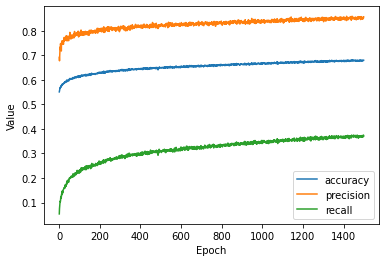

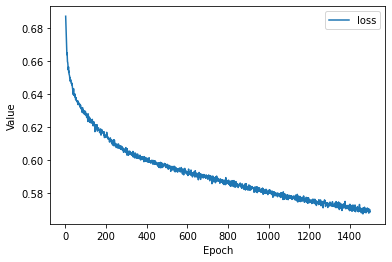

In [129]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 1500
batch_size = 25
classification_threshold = 0.70
label_name = "label"

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(
          name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(
          thresholds=classification_threshold, name='precision'),
      tf.keras.metrics.Recall(
          thresholds=classification_threshold, name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train, y_train, epochs, 
                          label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)
plot_curve(epochs, hist, ['loss'])

In [131]:
validation_performance =  my_model.evaluate(x_val, y_val, verbose=0)
print('')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])

loss:  0.8995556831359863
accuracy:  0.5727272629737854
precision:  0.550000011920929
recall:  0.22448979318141937
